# Waste Classification




### Table of Contents

* [Introduction](#introduction)
    * [Problem Statement](#proposal)
    * [Overview of Experiments](#experiments)
* [Dataset](#dataset)
    * [Overview](#datasetoverview)
* [Building CNN Models](#baselinemodels)
    * [Overview](#cnnoverview)
    * [Baseline B1](#b1)
        * [Utility Functions](#utilities)
        * [Data loading](#dataloaders)
        * [Compiling the model](#modelcompiling)
        * [Training the model](#modeltraining)
        * [Model Evaluation](#modelevaluation)
    * [Baseline B2](#b2)
        * [Baseline B2 32x32](#b2_32)
        * [Baseline B2 64x64](#b2_64)
        * [Baseline B2 128x128](#b2_128)
        * [Baseline B2 224x224](#b2_224)
        * [B2 Analysis](#b2analysis)
    * [Baseline B3](#b3)
        * [Baseline B3 128x128](#b3_128)
        * [Baseline B3 224x224](#b3_224)
        * [B3 Analysis](#b3analysis)
    * [Baseline B4](#b4)
        * [Baseline B4 A](#b4a)
        * [Baseline B4 B](#b4b)
        * [B4 Analysis](#b4analysis)
    * [Baseline B5](#b5) 
        * [Baseline B5 A](#b5a)
        * [Baseline B5 B](#b5b)
        * [B5 Analysis](#b5analysis)
    * [Baseline B6](#b6)
    * [Baseline B7](#b7)
    * [Analysis of Baseline Models](#baselineanalysis)
* [Transfer learning from pre-trained CNN Models](#transferlearning)
     * [Overview](#transferlearningoverview)
         * [Transfer Learning](#transferlearningintro)
         * [ResNet50](#resnet50overview)
     * [ResNet50 R1](#r1)
         * [ResNet50 R1 A](#r1a)
         * [ResNet50 R1 B](#r1b)
     * [ResNet50 R2](#r2)
     * [ResNet50 R3](#r3)
     * [Transfer Learning Analysis](#resnetanalysis)
* [Analysis](#analysis)

## Introduction <a class="anchor" id="introduction"></a>

### Problem Statement <a class="anchor" id="proposal"></a>
The task is to classify the images into Organic waste or Recyclable waste. The dataset is choosens from the [suggested](https://pradoposgrado2122.ugr.es/pluginfile.php/136436/mod_folder/content/0/Proposal.pdf?forcedownload=1) datasets for the project. Please find the link to original dataset [here](https://www.kaggle.com/datasets/techsash/waste-classification-data)



Multiple experiments creating CNN models, changing certain hyper parameters, finetuning the models, using pretrained models, adapting them to the data using transfer learning e.t.c have been conducted. 
The following sections gives an overview of all the experiments conducted

### Overview of Experiments <a class="anchor" id="experiments"></a>

| Experiment | Aim |
| --- | --- |
| Baseline B1 | To test the performance of a Baseline CNN structure, that will act as skeleton for further experiments |
| Baseline B2 | To test the effect of input image size on the performance of the model |
| Baseline B3 |  Increasing the depth of the model (adding more layers) to handle large image sizes and to check the effect of depth on the performance |
| Baseline B4 | To test the effect of different Data Normalization techniques on the performance |
| Baseline B4 A | Rescaling (Normalizing) input data to the range(0-1) |
| Baseline B4 B | Centering (Mean=0) & Standardizing (Standard Deviation) |
| Baseline B5 | To test the effect of different Data Augmentation (Training Transforms) on the performance |
| Baseline B5 A | Using aggressive data Augmentations |
| Baseline B5 B |Using Less aggressive data augmentations |
| Baseline B6 | To test the effect of using Batch Normalizations on the performance  |
| Baseline B7 | To test the effect of using Dropouts on the performance  |
| ResNet50  | Using pretrained ResNet50 network and adapting it to our task using transfer learning techniques|
| ResNet50 R1 A | Using the pretrained ResNet as it is, just changing the output/exit layer |
| ResNet50 R1 B | To test the effect of using  Data augmentations on ResNet50 R1 A |
| ResNet50 R2 | Using ResNet50 as feature extractor & Baseline B7 as the classifier on top of it.Freezing all the convolutional block parameters in ResNet50, removing all the fully connected blocks in ResNet50 and replacing them with Baseline B7.|
| ResNet50 R3 | Unfreezing all the layers from the entire ResNet50 R2 A network. Finetuning the ResNet50 to our data, using small learning rate |

#### Tenforflow-GPU
This is to check if the GPU is available and is being used  by Tensorflow & Keras

In [2]:
import tensorflow as tf

if tf.test.is_gpu_available():
    print("GPU available")
    print(f"Available devices : {tf.config.list_physical_devices('GPU')}")

GPU available
Available devices : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


##### Importing necessaary modules for performing I/O tasks and other tasks

In [3]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import random
random.seed(7)
import numpy as np
seed = 7

##### Setting the paths for Datasets 

In [4]:
DATA_PATH = "Data/"
TEST_PATH = "Data/TEST/"
TRAIN_PATH = "Data/TRAIN/"
VAL_PATH = "Data/VAL/"

## Dataset <a class="anchor" id="dataset"></a>


### Overview <a class="anchor" id="datasetoverview"></a>

Train : The part of dataset that is used to for training the model

Val : Validation data provides the first test against unseen data, providing an unbiased evaluation of a model fit, while tuning model hyperparameters

Test : The unseen samples of data, used for final evaluation



##### Primary analysis on the dataset - checking the dataset split i.e, number of samples in each train, val and test splits

In [11]:
print("Train Data")
print("__"*5)
Tr_splms = 0
for clas in os.listdir(TRAIN_PATH):
    Tr_splms += len(os.listdir(TRAIN_PATH+clas))
    print(f"Class {clas}, Number of samples = {len(os.listdir(TRAIN_PATH+clas))}")
print("__"*5)
print("Val Data")
print("__"*5)
Vl_splms = 0
for clas in os.listdir(VAL_PATH):
    Vl_splms += len(os.listdir(VAL_PATH+clas))
    print(f"Class {clas}, Number of samples = {len(os.listdir(VAL_PATH+clas))}")
print("__"*5)
print("Test Data")
print("__"*5)
Ts_splms = 0
for clas in os.listdir(TEST_PATH):
    Ts_splms += len(os.listdir(TEST_PATH+clas))
    print(f"Class {clas}, Number of samples = {len(os.listdir(TEST_PATH+clas))}")
tot = Tr_splms+Vl_splms+Ts_splms 
tr_r = (Tr_splms/tot)*100
vl_r = (Vl_splms/tot)*100
ts_r = (Ts_splms/tot)*100
print("__"*5)
print(f"Train : Validation : Test = {tr_r:.2f}% : {vl_r:.2f}% : {ts_r:.2f}%")
    

Train Data
__________
Class Organic, Number of samples = 5576
Class Recyclable, Number of samples = 4465
__________
Val Data
__________
Class Organic, Number of samples = 1262
Class Recyclable, Number of samples = 1012
__________
Test Data
__________
Class Organic, Number of samples = 1219
Class Recyclable, Number of samples = 1035
__________
Train : Validation : Test = 68.92% : 15.61% : 15.47%


| Dataset Split | Class | Samples |
| --- | --- | --- |
| Train | Organic | 5576 |
| Train | Recyclable | 4465 |
| Validation | Organic | 1262 |
| Validation | Recyclable | 1012 |
| Test | Organic | 1219 |
| Test | Recyclable | 1035 |

##### Displaying some sample images from the Dataset

Samples from Class Organic


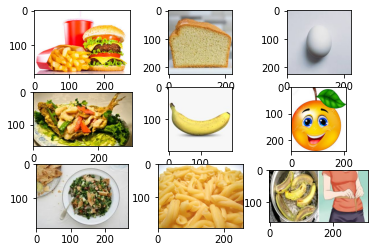

Samples from Class Recyclable


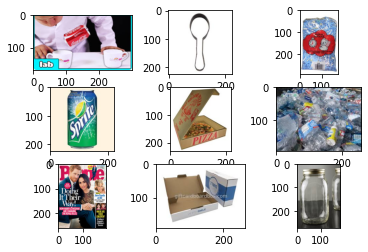

In [12]:
for clas in os.listdir(TRAIN_PATH):
    samples = os.listdir(TRAIN_PATH+clas)
    l = len(samples)
    for i in range(0,9):
        k = random.randint(0,l)
        im = Image.open(TRAIN_PATH+clas+"/"+samples[k])
        plt.subplot(3,3,i+1)
        plt.imshow(im)
    print(f"Samples from Class {clas}")
    plt.show()
    # break
for clas in os.listdir(TEST_PATH):
    samples = os.listdir(TEST_PATH+clas)
   

____

# Building CNN Models <a class="anchor" id="baselinemodels"></a>

## Overview <a class="anchor" id="cnnoverview"></a>

## Baseline B1 <a class="anchor" id="b1"></a>




This is to test the performance of a **Baseline CNN structure**, that will act as **skeleton** for further experiments.

The CNN model, has 2 convolution blocks that acts as feature extractor & 3 fully connected dense layers that act as classifier on top of the feature extractor.

Input size of image is set to [32x32]

Normalization of data, Data augments, Batch Normalizations, Dropout regularization etc. techniques are not used in this experiment B1. 

Early stopping is ensured so that the training process stops if the model is not learning anything in successive epochs. This is to prevent overfitting

### Utility Functions <a class="anchor" id="utilities"></a>

These are the functions that help us in plotting the validation accuracy, training accuracy, training loss, validation loss history during the training process. They also help us in evaluating the performance of the model, after training

In [5]:
import keras
from tensorflow import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.applications import imagenet_utils
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.models import load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten, Dropout,Activation, BatchNormalization


from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint


from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score


from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
 
import warnings
warnings.filterwarnings('ignore')



In [6]:
def PlotHistory(hist,ModelName):
    Accuracy = hist.history['accuracy']
    ValAccuracy = hist.history['val_accuracy']
    Loss = hist.history['loss']
    ValLoss = hist.history['val_loss']

    epochs = range(1, len(Accuracy)+1)
    
    plt.plot(epochs, Loss, 'g', label='Training')
    plt.plot(epochs, ValLoss, 'b', label='Validation')
    plt.title(f'Loss Over Epochs - {ModelName}')
    plt.legend()

    plt.figure()
    plt.plot(epochs, Accuracy, 'g', label='Training')
    plt.plot(epochs, ValAccuracy, 'b', label='Validation')
    plt.title(f'Accuracy Over Epochs - {ModelName}')
    plt.legend()
    plt.show()
    

In [7]:
def ConfusionMatrixMetrics(labels,preds):
    cfnm = confusion_matrix(labels,preds)
    cfnm_norm = confusion_matrix(labels,preds,normalize='true')
    pl = ConfusionMatrixDisplay(cfnm)
    pl.plot()
    pl.ax_.set_title("Confusion Matrix")
    plt.show()
    pl = ConfusionMatrixDisplay(cfnm_norm)
    pl.plot()
    pl.ax_.set_title("Confusion Matrix (Normalised)")
    plt.show()
    

### Callbacks
Checkpoint ensures to save the best model weights across epochs

Earlystop ensures to stop the training process, if the validation loss doesnt not decrease for sucessive epochs (we need to give the number of epochs in patience parameter)

reduce lr reduces the learning rate when the validation loss doesnot improve in sucessive epochs, this ensures that the model converges towards global optimum


In [8]:
#Checkpoints, to save the model
checkpoint = ModelCheckpoint("Checkpoints/BaseLine_B1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

#Early stopping, when the validation is not improving for sucessive epochs
earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0.0001, 
                          patience = 6,
                          verbose = 1,
                          restore_best_weights = True)

#Reducing the learning rate when the model is not converging
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 4,
                              verbose = 1,
                              min_delta = 0.0001)


callbacks = [earlystop, checkpoint, reduce_lr] #We will feed this to the model compiler

### Data loading <a class="anchor" id="dataloaders"></a>

In [9]:
#Configs
InputSize = [32,32] #Image Size
InputChannels = [3] #Number of Channels in the Image
InputShape = InputSize + InputChannels
Classes = os.listdir(TRAIN_PATH) 
Num_Classes = len(Classes) #Number of classes in the dataset

In [18]:
TrainDataGenerator = ImageDataGenerator()
ValDataGenerator  = ImageDataGenerator()
TestDataGenerator = ImageDataGenerator()

#Dataset that is used for training the model
TrainDataLoader = TrainDataGenerator.flow_from_directory(TRAIN_PATH,
                                                 target_size = InputSize,
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

#Dataset that is used for validating the performance of the model, during the training process
ValDataLoader = ValDataGenerator.flow_from_directory(VAL_PATH,
                                                 target_size = InputSize,
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

#Unseen Dataset, that is used for final evaluation of the model performance
TestDataLoader= TestDataGenerator.flow_from_directory(TEST_PATH,
                                            target_size = InputSize,
                                            batch_size = 16,
                                            class_mode = 'categorical',
                                            shuffle=False)



Found 10041 images belonging to 2 classes.
Found 2274 images belonging to 2 classes.
Found 2254 images belonging to 2 classes.


### Compiling the model <a class="anchor" id="modelcompiling"></a>


Categorical Cross Entropy loss is used as the loss function, as the current task is to categorise/classify the images.
Adam optimizer is used, as it is an proved optimiser that works well for optimising training process

In [19]:
BaseLine_B1 = Sequential([
  Conv2D(6, kernel_size=5, activation='relu',input_shape=InputShape),
  MaxPooling2D(),
  Conv2D(16, kernel_size=5, activation='relu',input_shape=InputShape),
  MaxPooling2D(),
  Flatten(),
  Dense(50, activation='relu'),
  Dense(25, activation='relu'),
  Dense(Num_Classes, activation='softmax')
])

#This is a simple model, with 2 convolutional layers and 3 dense layers. 

##### Model Summary

In [20]:
BaseLine_B1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         456       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 50)                2

In [21]:
BaseLine_B1.compile(
  loss='categorical_crossentropy',
 optimizer='adam',
  metrics=['accuracy']
)

### Training the model <a class="anchor" id="modeltraining"></a>

Though we have set the number of epochs as 30, the model will not train for all 30 epochs, it may exit the training process based on th early stopping criteria set above in callbacks

In [30]:
hist = BaseLine_B1.fit_generator(
  TrainDataLoader, 
  validation_data=ValDataLoader,
  epochs=30,
  steps_per_epoch=len(TrainDataLoader),
  validation_steps=len(ValDataLoader),
  callbacks = callbacks
)

#We use the train dataset for training the model and validatioon dataset for validating the model performance, during the training process

Epoch 1/30
628/628 [==============================] - ETA: 0s - loss: 0.3217 - accuracy: 0.8659
Epoch 1: val_loss did not improve from 0.44014
628/628 [==============================] - 9s 15ms/step - loss: 0.3217 - accuracy: 0.8659 - val_loss: 0.4603 - val_accuracy: 0.8135 - lr: 4.0000e-05
Epoch 2/30
628/628 [==============================] - ETA: 0s - loss: 0.3155 - accuracy: 0.8692
Epoch 2: val_loss did not improve from 0.44014
628/628 [==============================] - 8s 12ms/step - loss: 0.3155 - accuracy: 0.8692 - val_loss: 0.4664 - val_accuracy: 0.8127 - lr: 4.0000e-05
Epoch 3/30
628/628 [==============================] - ETA: 0s - loss: 0.3101 - accuracy: 0.8709
Epoch 3: val_loss did not improve from 0.44014
628/628 [==============================] - 8s 12ms/step - loss: 0.3101 - accuracy: 0.8709 - val_loss: 0.4714 - val_accuracy: 0.8166 - lr: 4.0000e-05
Epoch 4/30
628/628 [==============================] - ETA: 0s - loss: 0.3047 - accuracy: 0.8744
Epoch 4: val_loss did not im

### Model Evaluation <a class="anchor" id="modelevaluation"></a>

In [31]:
#Once the model training is done. We do the final evaluation of the model performance on test data, which is unseen till this stage
PredsB1 = BaseLine_B1.predict_generator(TestDataLoader) #making the class predictions on test data
PredsB1 = np.argmax(PredsB1,axis=1)

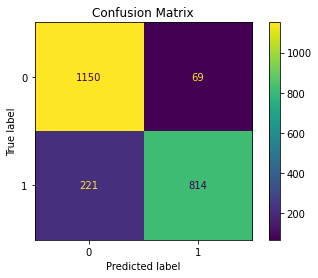

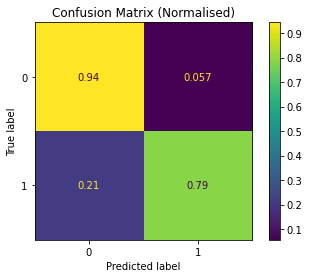

In [32]:
ConfusionMatrixMetrics(TestDataLoader.classes,PredsB1) #Calculating the confusion matrix. The utility function ConfusionMatrixMetric

In [34]:
acc_B1 = accuracy_score(TestDataLoader.classes,PredsB1) #Calculating the classification accuracy of the model
print(f'The model has an accuracy of {(acc_B1*100):.2f}%')

The model has an accuracy of 84.74%


In [19]:
print(classification_report(TestDataLoader.classes, PredsB1, target_names=Classes)) #Classification report gives us the details about precision, recall & f-score for each class

              precision    recall  f1-score   support

     Organic       0.80      0.95      0.87      1219
  Recyclable       0.93      0.72      0.81      1035

    accuracy                           0.85      2254
   macro avg       0.87      0.84      0.84      2254
weighted avg       0.86      0.85      0.84      2254



In [37]:
f1_B1 = 0.84 #Storing the f-score, for latter analysis

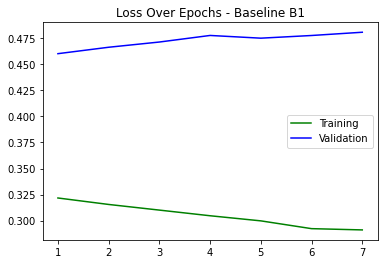

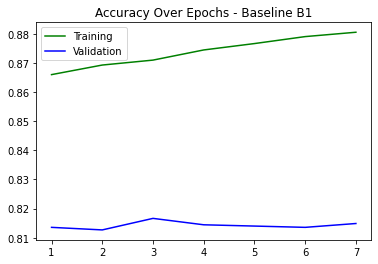

In [35]:
PlotHistory(hist,"Baseline B1") #This ustility function plots the Training Loss, Validation Loss, Training Accuracy, Validation Accuracy across the epochs

**Baseline B1 (with input image size [32x32]) yields an accuracy of 84.74% with an F-score of : 0.84.**

This is a good start.
Now that we have established a Baseline B1 model architecture that yields satisfactory results, we will use this as backbone for all our further tests. 

We have now, demonstrated the working of base architecture, early stop, callbacks, optimiser and loss function. These will be kept constant or same for further tests

_____________

## Baseline B2 <a class="anchor" id="b2"></a>

This is to test the effect of input size on the performance of the model

Previously, we have built a backbone network (Baseline B1) that acts as the skeleton for all of our exeperiments. next task is to find the appropriate Input Size and fix the Input Image Size

Now we try to increase the image size of Baseline B1 from [32x32] to [64x64],[128x128],[224x224] to check how perfromance changes with increasing input change.

It should be noted that, increasing input image size increases the computations needed. Thus, we need to find a proper tradeoff between size (computations) & performance improvement achieved

## Baseline B2 32x32 <a class="anchor" id="b2_32"></a>

Baseline B1 and Baseline B2 32x32 are the same

In [38]:
#With input image size as [32x32]
acc_B2_32 = acc_B1 
f1_B2_32 = f1_B1 



## Baseline B2 64x64 <a class="anchor" id="b2_64"></a>

In [23]:
#With input image size as [64x64]

#Configs
InputSize = [64,64]
InputChannels = [3]
InputShape = InputSize + InputChannels

TrainDataGenerator = ImageDataGenerator()
ValDataGenerator = ImageDataGenerator()
TestDataGenerator = ImageDataGenerator()

TrainDataLoader = TrainDataGenerator.flow_from_directory(TRAIN_PATH,
                                                 target_size = InputSize,
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

ValDataLoader = ValDataGenerator.flow_from_directory(VAL_PATH,
                                                 target_size = InputSize,
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

TestDataLoader= TestDataGenerator.flow_from_directory(TEST_PATH,
                                            target_size = InputSize,
                                            batch_size = 16,
                                            class_mode = 'categorical',
                                            shuffle=False)



Found 10041 images belonging to 2 classes.
Found 2274 images belonging to 2 classes.
Found 2254 images belonging to 2 classes.


####  Model architecture

In [24]:
BaseLine_B2_64 = Sequential([
  Conv2D(6, kernel_size=5, activation='relu',input_shape=InputShape),
  MaxPooling2D(),
  Conv2D(16, kernel_size=5, activation='relu',input_shape=InputShape),
  MaxPooling2D(),
  Flatten(),
  Dense(50, activation='relu'),
  Dense(25, activation='relu'),
  Dense(Num_Classes, activation='softmax')
])

#### Model Summary

In [25]:
BaseLine_B2_64.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 60, 60, 6)         456       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 6)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 16)        2416      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 16)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 2704)              0         
                                                                 
 dense_3 (Dense)             (None, 50)               

In [26]:
BaseLine_B2_64.compile(
  loss='categorical_crossentropy',
 optimizer='adam',
  metrics=['accuracy']
)

In [27]:
hist = BaseLine_B2_64.fit_generator(
  TrainDataLoader,
  validation_data=ValDataLoader,
  epochs=30,
  steps_per_epoch=len(TrainDataLoader),
  validation_steps=len(ValDataLoader),
  callbacks = callbacks
)

Epoch 1/30
623/628 [============================>.] - ETA: 0s - loss: 1.1289 - accuracy: 0.6964
Epoch 1: val_loss did not improve from 0.46045
628/628 [==============================] - 7s 10ms/step - loss: 1.1245 - accuracy: 0.6971 - val_loss: 0.6076 - val_accuracy: 0.6939 - lr: 0.0010
Epoch 2/30
623/628 [============================>.] - ETA: 0s - loss: 0.4880 - accuracy: 0.7861
Epoch 2: val_loss improved from 0.46045 to 0.45577, saving model to Checkpoints\BaseLine_B1.h5
628/628 [==============================] - 7s 11ms/step - loss: 0.4877 - accuracy: 0.7861 - val_loss: 0.4558 - val_accuracy: 0.8105 - lr: 0.0010
Epoch 3/30
624/628 [============================>.] - ETA: 0s - loss: 0.4367 - accuracy: 0.8143
Epoch 3: val_loss did not improve from 0.45577
628/628 [==============================] - 6s 10ms/step - loss: 0.4371 - accuracy: 0.8143 - val_loss: 0.4918 - val_accuracy: 0.7889 - lr: 0.0010
Epoch 4/30
626/628 [============================>.] - ETA: 0s - loss: 0.4040 - accuracy:

##### Model Evaluation

In [28]:
PredsB2_64 = BaseLine_B2_64.predict_generator(TestDataLoader)
PredsB2_64 = np.argmax(PredsB2_64,axis=1)

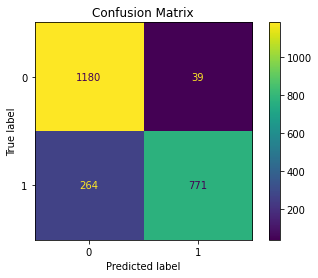

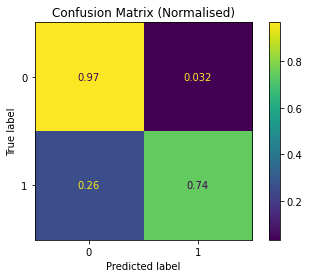

In [29]:
ConfusionMatrixMetrics(TestDataLoader.classes,PredsB2_64)

In [48]:
acc_B2_64 =  accuracy_score(TestDataLoader.classes,PredsB2_64)

print(f'The model has an accuracy of {(acc_B2_64*100):.2f}%')

The model has an accuracy of 86.56%


In [31]:
print(classification_report(TestDataLoader.classes, PredsB2_64, target_names=Classes))

              precision    recall  f1-score   support

     Organic       0.82      0.97      0.89      1219
  Recyclable       0.95      0.74      0.84      1035

    accuracy                           0.87      2254
   macro avg       0.88      0.86      0.86      2254
weighted avg       0.88      0.87      0.86      2254



In [32]:
f1_B2_64 = 0.86

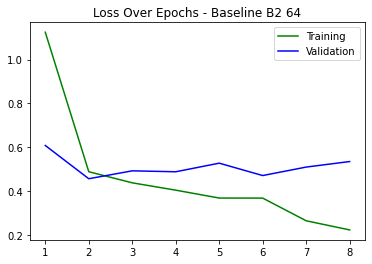

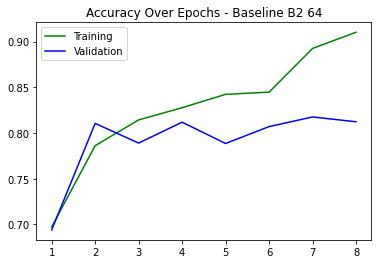

In [33]:
PlotHistory(hist,"Baseline B2 64")


**Baseline B2 (with input image size [64x64]) yields an accuracy of 86.56% with an F-score of : 0.86.**

This is a slight improvement over the mode with input size [32x32]

____

## Baseline B2 128x128 <a class="anchor" id="b2_128"></a>

In [40]:
#With input image size as [128x128]

#Configs
InputSize = [128,128]
InputChannels = [3]
InputShape = InputSize + InputChannels

TrainDataGenerator = ImageDataGenerator()
TestDataGenerator = ImageDataGenerator()

TrainDataLoader = TrainDataGenerator.flow_from_directory(TRAIN_PATH,
                                                 target_size = InputSize,
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

ValDataLoader = TrainDataGenerator.flow_from_directory(VAL_PATH,
                                                 target_size = InputSize,
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

TestDataLoader= TestDataGenerator.flow_from_directory(TEST_PATH,
                                            target_size = InputSize,
                                            batch_size = 16,
                                            class_mode = 'categorical',
                                            shuffle=False)



Found 10041 images belonging to 2 classes.
Found 2274 images belonging to 2 classes.
Found 2254 images belonging to 2 classes.


#####  Model architecture

In [42]:
BaseLine_B2_128 = Sequential([
  Conv2D(6, kernel_size=5, activation='relu',input_shape=InputShape),
  MaxPooling2D(),
  Conv2D(16, kernel_size=5, activation='relu',input_shape=InputShape),
  MaxPooling2D(),
  Flatten(),
  Dense(50, activation='relu'),
  Dense(25, activation='relu'),
  Dense(Num_Classes, activation='softmax')
])

##### Model Summary

In [43]:
BaseLine_B2_128.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 124, 124, 6)       456       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 6)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 58, 58, 16)        2416      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 29, 29, 16)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 13456)             0         
                                                                 
 dense_6 (Dense)             (None, 50)               

In [44]:
BaseLine_B2_128.compile(
  loss='categorical_crossentropy',
 optimizer='adam',
  metrics=['accuracy']
)

In [52]:


checkpoint = ModelCheckpoint("Checkpoints/BaseLine_B1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0.0001, 
                          patience = 6,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 2,
                              verbose = 1,
                              min_delta = 0.0001)


callbacks = [earlystop, checkpoint, reduce_lr]

In [53]:
hist = BaseLine_B2_128.fit_generator(
  TrainDataLoader,
  validation_data=ValDataLoader,
  epochs=30,
  steps_per_epoch=len(TrainDataLoader),
  validation_steps=len(ValDataLoader),
  callbacks = callbacks
)

Epoch 1/30
625/628 [============================>.] - ETA: 0s - loss: 0.1913 - accuracy: 0.9301
Epoch 1: val_loss improved from inf to 0.57039, saving model to Checkpoints\BaseLine_B1.h5
628/628 [==============================] - 9s 14ms/step - loss: 0.1911 - accuracy: 0.9302 - val_loss: 0.5704 - val_accuracy: 0.8091 - lr: 4.0000e-05
Epoch 2/30
626/628 [============================>.] - ETA: 0s - loss: 0.1524 - accuracy: 0.9438
Epoch 2: val_loss did not improve from 0.57039
628/628 [==============================] - 8s 13ms/step - loss: 0.1525 - accuracy: 0.9437 - val_loss: 0.6052 - val_accuracy: 0.8087 - lr: 4.0000e-05
Epoch 3/30
628/628 [==============================] - ETA: 0s - loss: 0.1236 - accuracy: 0.9571
Epoch 3: val_loss did not improve from 0.57039

Epoch 3: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
628/628 [==============================] - 8s 13ms/step - loss: 0.1236 - accuracy: 0.9571 - val_loss: 0.6865 - val_accuracy: 0.8140 - lr: 4.0000e-05
Epo

##### Model Evaluation

In [54]:
PredsB2_128 = BaseLine_B2_128.predict_generator(TestDataLoader)
PredsB2_128 = np.argmax(PredsB2_128,axis=1)

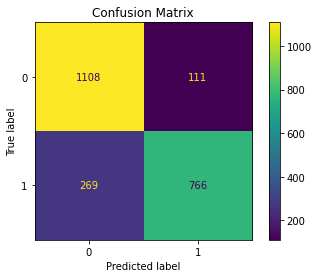

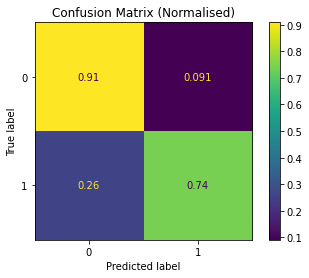

In [55]:
ConfusionMatrixMetrics(TestDataLoader.classes,PredsB2_128)

In [57]:
acc_B2_128 =  accuracy_score(TestDataLoader.classes,PredsB2_128)

print(f'The model has an accuracy of {(acc_B2_128*100):.2f}%')

The model has an accuracy of 83.14%


In [58]:
print(classification_report(TestDataLoader.classes, PredsB2_128, target_names=Classes))

              precision    recall  f1-score   support

     Organic       0.80      0.91      0.85      1219
  Recyclable       0.87      0.74      0.80      1035

    accuracy                           0.83      2254
   macro avg       0.84      0.82      0.83      2254
weighted avg       0.84      0.83      0.83      2254



In [59]:
f1_B2_128 = 0.83

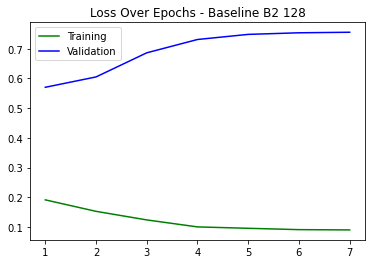

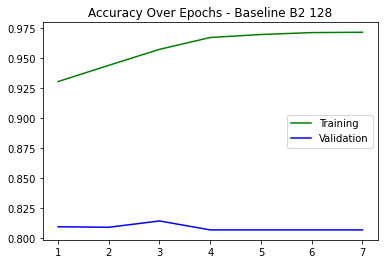

In [60]:
PlotHistory(hist,"Baseline B2 128")

##### Analysis
**Baseline B2 (with input image size [128x128]) yields an accuracy of 83.14% with an F-score of : 0.83.**

This is a slight decrease in performance compared to models with input size [32x32] & [64x64]

## Baseline B2 224x224 <a class="anchor" id="b2_224"></a>

In [65]:
#With input image size as [224x224]

#Configs
InputSize = [224,224]
InputChannels = [3]
InputShape = InputSize + InputChannels

TrainDataGenerator = ImageDataGenerator()
TestDataGenerator = ImageDataGenerator()

TrainDataLoader = TrainDataGenerator.flow_from_directory(TRAIN_PATH,
                                                 target_size = InputSize,
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

ValDataLoader = TrainDataGenerator.flow_from_directory(VAL_PATH,
                                                 target_size = InputSize,
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

TestDataLoader= TestDataGenerator.flow_from_directory(TEST_PATH,
                                            target_size = InputSize,
                                            batch_size = 16,
                                            class_mode = 'categorical',
                                            shuffle=False)



Found 10041 images belonging to 2 classes.
Found 2274 images belonging to 2 classes.
Found 2254 images belonging to 2 classes.


##### Model Architecture

In [66]:
BaseLine_B2_224 = Sequential([
  Conv2D(6, kernel_size=5, activation='relu',input_shape=InputShape),
  MaxPooling2D(),
  Conv2D(16, kernel_size=5, activation='relu',input_shape=InputShape),
  MaxPooling2D(),
  Flatten(),
  Dense(50, activation='relu'),
  Dense(25, activation='relu'),
  Dense(Num_Classes, activation='softmax')
])

##### Model Summary

In [67]:
BaseLine_B2_224.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 220, 220, 6)       456       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 110, 110, 6)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 106, 106, 16)      2416      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 53, 53, 16)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 44944)             0         
                                                                 
 dense_12 (Dense)            (None, 50)               

In [68]:
BaseLine_B2_224.compile(
  loss='categorical_crossentropy',
 optimizer='adam',
  metrics=['accuracy']
)

In [69]:
# Creating a checkpointer 

checkpoint = ModelCheckpoint("Checkpoints/BaseLine_B2_224.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0.0001, 
                          patience = 6,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 2,
                              verbose = 1,
                              min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

In [70]:
hist = BaseLine_B2_224.fit_generator(
  TrainDataLoader,
  validation_data=ValDataLoader,
  epochs=30,
  steps_per_epoch=len(TrainDataLoader),
  validation_steps=len(ValDataLoader),
  callbacks = callbacks
)

Epoch 1/30
626/628 [============================>.] - ETA: 0s - loss: 6.6510 - accuracy: 0.7194
Epoch 1: val_loss improved from inf to 0.51260, saving model to Checkpoints\BaseLine_B2_224.h5
628/628 [==============================] - 14s 22ms/step - loss: 6.6319 - accuracy: 0.7195 - val_loss: 0.5126 - val_accuracy: 0.7762 - lr: 0.0010
Epoch 2/30
625/628 [============================>.] - ETA: 0s - loss: 0.4340 - accuracy: 0.8181
Epoch 2: val_loss did not improve from 0.51260
628/628 [==============================] - 14s 22ms/step - loss: 0.4342 - accuracy: 0.8179 - val_loss: 0.5969 - val_accuracy: 0.7282 - lr: 0.0010
Epoch 3/30
626/628 [============================>.] - ETA: 0s - loss: 0.2890 - accuracy: 0.8860
Epoch 3: val_loss did not improve from 0.51260

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
628/628 [==============================] - 14s 22ms/step - loss: 0.2885 - accuracy: 0.8863 - val_loss: 0.6909 - val_accuracy: 0.7709 - lr: 0.0010
Epoch 4

##### Model Evaluation

In [71]:
PredsB2_224 = BaseLine_B2_224.predict_generator(TestDataLoader)
PredsB2_224 = np.argmax(PredsB2_224,axis=1)

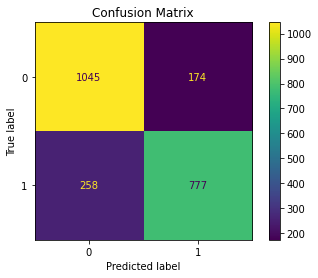

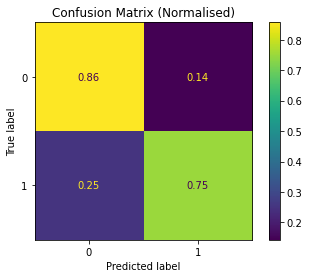

In [72]:
ConfusionMatrixMetrics(TestDataLoader.classes,PredsB2_224)

In [73]:
acc_B2_224 =  accuracy_score(TestDataLoader.classes,PredsB2_224)

print(f'The model has an accuracy of {(acc_B2_224*100):.2f}%')

The model has an accuracy of 80.83%


In [74]:
print(classification_report(TestDataLoader.classes, PredsB2_224, target_names=Classes))

              precision    recall  f1-score   support

     Organic       0.80      0.86      0.83      1219
  Recyclable       0.82      0.75      0.78      1035

    accuracy                           0.81      2254
   macro avg       0.81      0.80      0.81      2254
weighted avg       0.81      0.81      0.81      2254



In [75]:
f1_B2_64 = 0.81

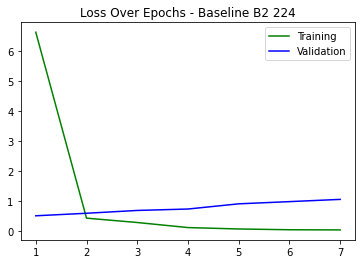

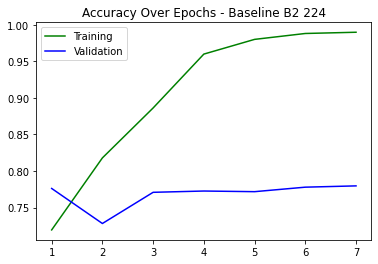

In [76]:
PlotHistory(hist,"Baseline B2 224")


**Baseline B2 (with input image size [224x224]) yields an accuracy of 80.83% with an F-score of : 0.81.**

This is decrease in performance compared to the previously tested configurations.

### B2 Analysis <a class="anchor" id="b2analysis"></a>

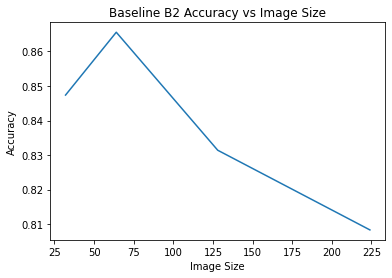

In [83]:
#Lets plot the Acuracy achieved vs Input Image Size used in the model
plt.plot([32,64,128,224],[acc_B2_32,acc_B2_64,acc_B2_128,acc_B2_224])
plt.title("Baseline B2 Accuracy vs Image Size")
plt.xlabel("Image Size")
plt.ylabel("Accuracy")
plt.show()


From the above experiments, we can clearly see that, increasing the image size initially increases the accuracy but then decreases the accuracy from size 64. This might be because the network is too small (few layers) to actuually learn patterns in the data, it is unable to converge to the global optima, on the big sized images data and not actually learning anything.

We need to impove the network size to handle big images, this way we can improve the overall accuracy of the model as well

________________________________________________________________________________________________________________

## Baseline B3

Adding more layers and increasing the number of filters, to enable the network to handle big size images and extract patterns from big sized images without overfitting. Also, adding more layers enables the model to model more complex functions.

## Baseline B3 128x128 <a class="anchor" id="b3_128"></a>

In [103]:
InputShape = [128,128,3]

In [104]:
BaseLine_B3 = Sequential([
  Conv2D(32, kernel_size=5, activation='relu',input_shape=InputShape),
  MaxPooling2D(),
  Conv2D(64, kernel_size=5, activation='relu'),
  MaxPooling2D(),
  Conv2D(128, kernel_size=5, activation='relu'),
  MaxPooling2D(),
  Conv2D(256, kernel_size=5, activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(512, activation='relu'),
  Dense(256, activation='relu'),
  Dense(128, activation='relu'),
  Dense(Num_Classes, activation='softmax')
])

In [105]:
#With input image size as [128x128]


InputSize = [128,128]
InputChannels = [3]
InputShape = InputSize + InputChannels

TrainDataGenerator = ImageDataGenerator()
ValDataGenerator = ImageDataGenerator()
TestDataGenerator = ImageDataGenerator()

TrainDataLoader = TrainDataGenerator.flow_from_directory(TRAIN_PATH,
                                                 target_size = InputSize,
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

ValDataLoader = ValDataGenerator.flow_from_directory(VAL_PATH,
                                                 target_size = InputSize,
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

TestDataLoader= TestDataGenerator.flow_from_directory(TEST_PATH,
                                            target_size = InputSize,
                                            batch_size = 16,
                                            class_mode = 'categorical',
                                            shuffle=False)



Found 10041 images belonging to 2 classes.
Found 2274 images belonging to 2 classes.
Found 2254 images belonging to 2 classes.


In [106]:
BaseLine_B3_128 = Sequential([
  Conv2D(32, kernel_size=5, activation='relu',input_shape=InputShape),
  MaxPooling2D(),
  Conv2D(64, kernel_size=5, activation='relu'),
  MaxPooling2D(),
  Conv2D(128, kernel_size=5, activation='relu'),
  MaxPooling2D(),
  Conv2D(256, kernel_size=5, activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(512, activation='relu'),
  Dense(256, activation='relu'),
  Dense(128, activation='relu'),
  Dense(Num_Classes, activation='softmax')
])

In [107]:
BaseLine_B3_128.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_58 (Conv2D)          (None, 124, 124, 32)      2432      
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_59 (Conv2D)          (None, 58, 58, 64)        51264     
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 29, 29, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_60 (Conv2D)          (None, 25, 25, 128)       204928    
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 12, 12, 128)    

In [108]:
BaseLine_B3_128.compile(
  loss='categorical_crossentropy',
 optimizer='adam',
  metrics=['accuracy']
)

In [111]:
hist = BaseLine_B3_128.fit_generator(
  TrainDataLoader,
  validation_data=ValDataLoader,
  epochs=30,
  steps_per_epoch=len(TrainDataLoader),
  validation_steps=len(ValDataLoader),
  callbacks = callbacks
)

Epoch 1/30
626/628 [============================>.] - ETA: 0s - loss: 0.4796 - accuracy: 0.7932
Epoch 1: val_loss improved from inf to 0.42604, saving model to Checkpoints\BaseLine_B1.h5
628/628 [==============================] - 14s 23ms/step - loss: 0.4796 - accuracy: 0.7930 - val_loss: 0.4260 - val_accuracy: 0.8188 - lr: 0.0010
Epoch 2/30
628/628 [==============================] - ETA: 0s - loss: 0.4279 - accuracy: 0.8216
Epoch 2: val_loss improved from 0.42604 to 0.39955, saving model to Checkpoints\BaseLine_B1.h5
628/628 [==============================] - 14s 22ms/step - loss: 0.4279 - accuracy: 0.8216 - val_loss: 0.3995 - val_accuracy: 0.8373 - lr: 0.0010
Epoch 3/30
627/628 [============================>.] - ETA: 0s - loss: 0.4032 - accuracy: 0.8334
Epoch 3: val_loss improved from 0.39955 to 0.39186, saving model to Checkpoints\BaseLine_B1.h5
628/628 [==============================] - 14s 22ms/step - loss: 0.4030 - accuracy: 0.8336 - val_loss: 0.3919 - val_accuracy: 0.8351 - lr: 

In [112]:
PredsB3_128 = BaseLine_B3_128.predict_generator(TestDataLoader)
PredsB3_128 = np.argmax(PredsB3_128,axis=1)

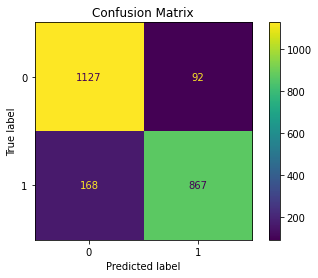

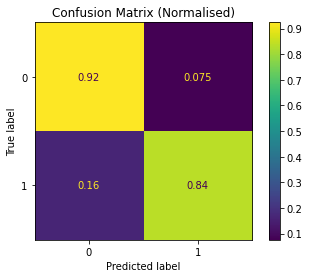

In [113]:
ConfusionMatrixMetrics(TestDataLoader.classes,PredsB3_128)

In [114]:
acc_B3_128 =  accuracy_score(TestDataLoader.classes,PredsB3_128)

print(f'The model has an accuracy of {(acc_B3_128*100):.2f}%')

The model has an accuracy of 88.46%


In [115]:
print(classification_report(TestDataLoader.classes, PredsB3_128, target_names=Classes))

              precision    recall  f1-score   support

     Organic       0.87      0.92      0.90      1219
  Recyclable       0.90      0.84      0.87      1035

    accuracy                           0.88      2254
   macro avg       0.89      0.88      0.88      2254
weighted avg       0.89      0.88      0.88      2254



In [116]:
f1_B3_128 = 0.88

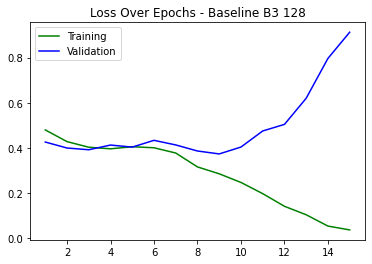

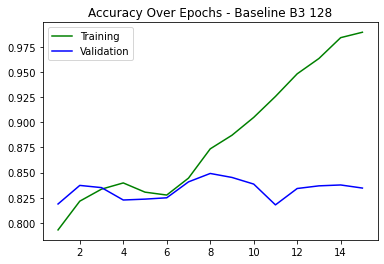

In [117]:
PlotHistory(hist,"Baseline B3 128")


**The model Baseline B3 128x128 has achieved an accuracy of 88.46% with an F-score of 0.88**

This is an increase in performance compared to B2 32x32 & B2 64x64

## Baseline B3 224x224 <a class="anchor" id="b3_224"></a>

In [101]:
#With input image size as [224x224]

#Configs
InputSize = [224,224]
InputChannels = [3]
InputShape = InputSize + InputChannels

TrainDataGenerator = ImageDataGenerator()
TestDataGenerator = ImageDataGenerator()

TrainDataLoader = TrainDataGenerator.flow_from_directory(TRAIN_PATH,
                                                 target_size = InputSize,
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

ValDataLoader = TrainDataGenerator.flow_from_directory(VAL_PATH,
                                                 target_size = InputSize,
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

TestDataLoader= TestDataGenerator.flow_from_directory(TEST_PATH,
                                            target_size = InputSize,
                                            batch_size = 16,
                                            class_mode = 'categorical',
                                            shuffle=False)



Found 10041 images belonging to 2 classes.
Found 2274 images belonging to 2 classes.
Found 2254 images belonging to 2 classes.


In [102]:
BaseLine_B3_224 = Sequential([
  Conv2D(32, kernel_size=5, activation='relu',input_shape=InputShape),
  MaxPooling2D(),
  Conv2D(64, kernel_size=5, activation='relu'),
  MaxPooling2D(),
  Conv2D(128, kernel_size=5, activation='relu'),
  MaxPooling2D(),
  Conv2D(256, kernel_size=5, activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(512, activation='relu'),
  Dense(256, activation='relu'),
  Dense(128, activation='relu'),
  Dense(Num_Classes, activation='softmax')
])

In [103]:
BaseLine_B3_224.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 220, 220, 32)      2432      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 110, 110, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 106, 106, 64)      51264     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 53, 53, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 49, 49, 128)       204928    
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 24, 24, 128)     

In [104]:
BaseLine_B3_224.compile(
  loss='categorical_crossentropy',
 optimizer='adam',
  metrics=['accuracy']
)

In [105]:
# Creating a checkpointer 

checkpoint = ModelCheckpoint("Checkpoints/BaseLine_B1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0.0001, 
                          patience = 6,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 4,
                              verbose = 1,
                              min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

In [106]:
hist = BaseLine_B3_224.fit_generator(
  TrainDataLoader,
  validation_data=ValDataLoader,
  epochs=30,
  steps_per_epoch=len(TrainDataLoader),
  validation_steps=len(ValDataLoader),
  callbacks = callbacks
)

Epoch 1/30
628/628 [==============================] - ETA: 0s - loss: 2.5594 - accuracy: 0.7774
Epoch 1: val_loss improved from inf to 0.48992, saving model to Checkpoints\BaseLine_B1.h5
628/628 [==============================] - 36s 56ms/step - loss: 2.5594 - accuracy: 0.7774 - val_loss: 0.4899 - val_accuracy: 0.7999 - lr: 0.0010
Epoch 2/30
628/628 [==============================] - ETA: 0s - loss: 0.4438 - accuracy: 0.8115
Epoch 2: val_loss improved from 0.48992 to 0.42482, saving model to Checkpoints\BaseLine_B1.h5
628/628 [==============================] - 36s 57ms/step - loss: 0.4438 - accuracy: 0.8115 - val_loss: 0.4248 - val_accuracy: 0.8188 - lr: 0.0010
Epoch 3/30
628/628 [==============================] - ETA: 0s - loss: 0.4838 - accuracy: 0.8138
Epoch 3: val_loss did not improve from 0.42482
628/628 [==============================] - 36s 58ms/step - loss: 0.4838 - accuracy: 0.8138 - val_loss: 0.6713 - val_accuracy: 0.6073 - lr: 0.0010
Epoch 4/30
628/628 [=====================

In [107]:
PredsB3_224 = BaseLine_B3_224.predict_generator(TestDataLoader)
PredsB3_224 = np.argmax(PredsB3_224,axis=1)

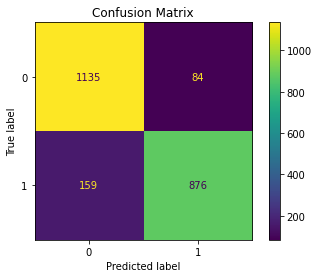

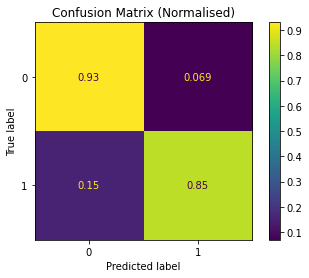

In [108]:
ConfusionMatrixMetrics(TestDataLoader.classes,PredsB3_224)

In [109]:
acc_B3_224 =  accuracy_score(TestDataLoader.classes,PredsB3_224)

print(f'The model has an accuracy of {(acc_B3_224*100):.2f}%')

The model has an accuracy of 89.22%


In [110]:
print(classification_report(TestDataLoader.classes, PredsB3_224, target_names=Classes))

              precision    recall  f1-score   support

     Organic       0.88      0.93      0.90      1219
  Recyclable       0.91      0.85      0.88      1035

    accuracy                           0.89      2254
   macro avg       0.89      0.89      0.89      2254
weighted avg       0.89      0.89      0.89      2254



In [128]:
f1_B3_224 = 0.89

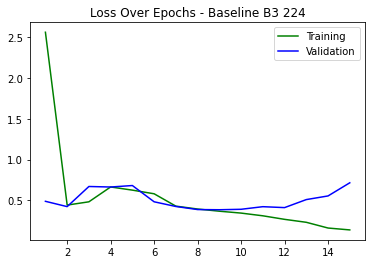

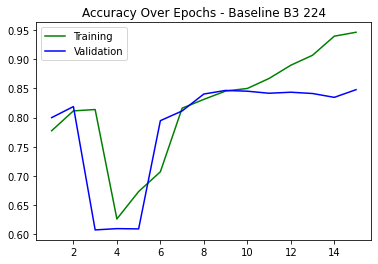

In [111]:
PlotHistory(hist,"Baseline B3 224")

**The model Baseline B3 224x224 has achieved an accuracy of 89.22% with an F-score of 0.89**

This is a significant increaase in perfomance, compared to previous models and input sizes

## B3 Analysis <a class="anchor" id="b3analysis"></a>

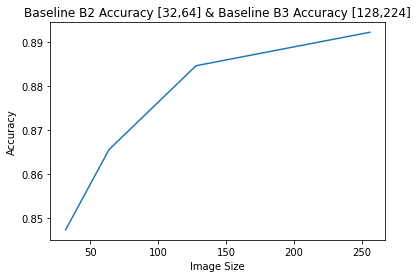

In [121]:
plt.plot([32,64,128,256],[acc_B2_32, acc_B2_64, acc_B3_128, acc_B3_224])
plt.title("Baseline B2 Accuracy [32,64] & Baseline B3 Accuracy [128,224]")
plt.xlabel("Image Size")
plt.ylabel("Accuracy")
plt.show()

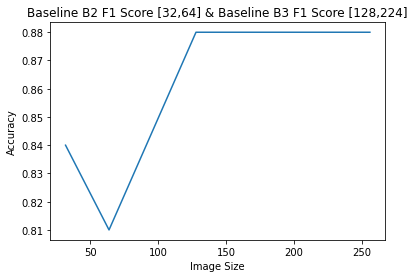

In [137]:
plt.plot([32,64,128,256],[f1_B2_32, f1_B2_64, f1_B3_128, f1_B3_224])
plt.title("Baseline B2 F1 Score [32,64] & Baseline B3 F1 Score [128,224]")
plt.xlabel("Image Size")
plt.ylabel("Accuracy")
plt.show()

From the above plot, we can see that Baseline B3 (with added layers) with an input size 224x224 gives the best results. Increasing the size of input has increase the performance. Hence, we will fix the input size of image size as 224x224 for our further tests

For further experiments, we will use B3 as the backbone, fine tune it and use additional teachniques to improve the overall performance.
We will also use the input image size as 224x224 for all the further experiments

__________________________________________________________

## Baseline B4 <a class="anchor" id="b4"></a>

This is an update on Baseline B1 architecture. Baseline B1 has produces satisfactory results to prove that the model can acts as the backbone for our task.

Now the task at hand is to finetune and modify the Baseline B1 architecture to improve the accuracy & performance of the model

In this step, we explore data normalisation techniques, to see how data normalisation effects the perfromance of the model

We test two different normalisation techniques (Pixel Normalisation, Pixel centering & Pixel Standarization), to find out which one yields better results for our model

if this modification improves the accuracy, this modification will be carried on to further steps

## Baseline B4 A <a class="anchor" id="b4a"></a>

A) Pixel Normalisation : (rescale=1.0/255.0) rescales pixel values of the image from range 0-255 to range 0-1.

In [122]:
InputSize = [224,224]
InputChannels = [3]
InputShape = InputSize + InputChannels

In [123]:


TrainDataGenerator = ImageDataGenerator(rescale=1./255) #Scaling the data to 0-1 (normalising the data to the sccale of 0-1)
ValDataGenerator = ImageDataGenerator(rescale=1./255)
TestDataGenerator = ImageDataGenerator(rescale = 1./255)

TrainDataLoader = TrainDataGenerator.flow_from_directory(TRAIN_PATH,
                                                 target_size = InputSize,
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

ValDataLoader = ValDataGenerator.flow_from_directory(VAL_PATH,
                                                 target_size = InputSize,
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

TestDataLoader= TestDataGenerator.flow_from_directory(TEST_PATH,
                                            target_size = InputSize,
                                            batch_size = 16,
                                            class_mode = 'categorical',
                                            shuffle=False)



Found 10041 images belonging to 2 classes.
Found 2274 images belonging to 2 classes.
Found 2254 images belonging to 2 classes.


In [124]:
BaseLine_B4_A = Sequential([
  Conv2D(32, kernel_size=5, activation='relu',input_shape=InputShape),
  MaxPooling2D(),
  Conv2D(64, kernel_size=5, activation='relu'),
  MaxPooling2D(),
  Conv2D(128, kernel_size=5, activation='relu'),
  MaxPooling2D(),
  Conv2D(256, kernel_size=5, activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(512, activation='relu'),
  Dense(256, activation='relu'),
  Dense(128, activation='relu'),
  Dense(Num_Classes, activation='softmax')
])

In [125]:
BaseLine_B4_A.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 220, 220, 32)      2432      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 110, 110, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 106, 106, 64)      51264     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 53, 53, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 49, 49, 128)       204928    
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 24, 24, 128)     

In [126]:
BaseLine_B4_A.compile(
  loss='categorical_crossentropy',
 optimizer='adam',
  metrics=['accuracy']
)

In [127]:
hist = BaseLine_B4_A.fit_generator(
  TrainDataLoader,
  validation_data=ValDataLoader,
  epochs=30,
  steps_per_epoch=len(TrainDataLoader),
  validation_steps=len(ValDataLoader),
  callbacks = callbacks
)

Epoch 1/30
627/628 [============================>.] - ETA: 0s - loss: 0.5016 - accuracy: 0.7794
Epoch 1: val_loss did not improve from 0.38671
628/628 [==============================] - 34s 53ms/step - loss: 0.5017 - accuracy: 0.7793 - val_loss: 0.4959 - val_accuracy: 0.7960 - lr: 0.0010
Epoch 2/30
627/628 [============================>.] - ETA: 0s - loss: 0.4571 - accuracy: 0.8029
Epoch 2: val_loss did not improve from 0.38671
628/628 [==============================] - 34s 55ms/step - loss: 0.4571 - accuracy: 0.8029 - val_loss: 0.4599 - val_accuracy: 0.7885 - lr: 0.0010
Epoch 3/30
628/628 [==============================] - ETA: 0s - loss: 0.4167 - accuracy: 0.8269
Epoch 3: val_loss did not improve from 0.38671
628/628 [==============================] - 35s 55ms/step - loss: 0.4167 - accuracy: 0.8269 - val_loss: 0.4075 - val_accuracy: 0.8267 - lr: 0.0010
Epoch 4/30
627/628 [============================>.] - ETA: 0s - loss: 0.4151 - accuracy: 0.8265
Epoch 4: val_loss did not improve fro

In [128]:
PredsB4_A = BaseLine_B4_A.predict_generator(TestDataLoader)
PredsB4_A = np.argmax(PredsB4_A,axis=1)

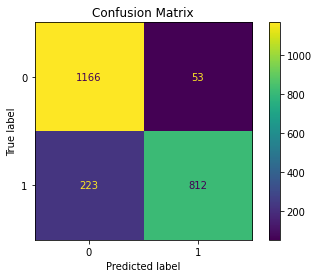

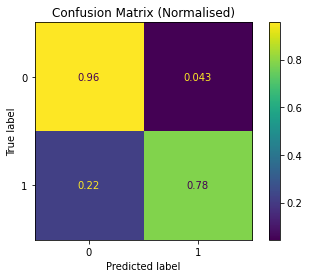

In [129]:
ConfusionMatrixMetrics(TestDataLoader.classes,PredsB4_A)

In [130]:
acc_B4_A =  accuracy_score(TestDataLoader.classes,PredsB4_A)

print(f'The model has an accuracy of {(acc_B4_A*100):.2f}%')

The model has an accuracy of 87.76%


In [131]:
print(classification_report(TestDataLoader.classes, PredsB4_A, target_names=Classes))

              precision    recall  f1-score   support

     Organic       0.84      0.96      0.89      1219
  Recyclable       0.94      0.78      0.85      1035

    accuracy                           0.88      2254
   macro avg       0.89      0.87      0.87      2254
weighted avg       0.89      0.88      0.88      2254



In [132]:
f1_B4_A = 0.88

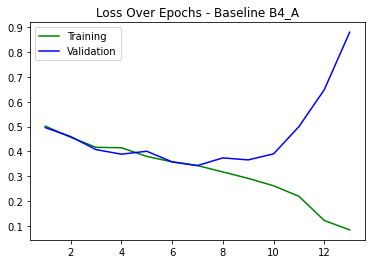

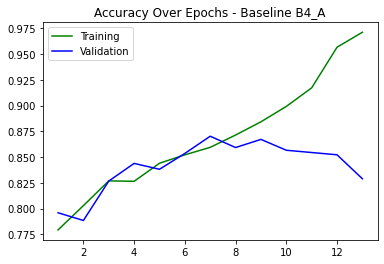

In [133]:
PlotHistory(hist,"Baseline B4_A")

**The model Baseline B4 A has achieved an accuracy of 87.76% with an F-score of 0.87**

_________________________________

## Baseline B4 B <a class="anchor" id="b4b"></a>

In [174]:
InputSize = [224,224]
InputChannels = [3]
InputShape = InputSize + InputChannels

In [12]:
from pathlib import Path

#Loading all images
height,width = InputSize

def read_pil_image(img_path, height, width):
        with open(img_path, 'rb') as f:
            return np.array(Image.open(f).convert('RGB').resize((width, height)))

def load_all_images(dataset_path, height, width, img_ext='jpg'):
    return np.array([read_pil_image(str(p), height, width) for p in Path(dataset_path).rglob("*."+img_ext)]) 



We need to first calculate the mean statistics from all the images in the dataset, we use these statistics to center all the inpus (to make mean=zero) and standardise the inputs (range 0-1)

In [176]:
#featurewise_center=True centers all the pixels (Mean=0) and featurewise_std_normalisation standardisaes
#all the pixels (standard deviation = 1)
TrainDataGenerator = ImageDataGenerator(rescale=1./255, featurewise_center=True, featurewise_std_normalization=True,)
ValDataGenerator = ImageDataGenerator(rescale=1./255, featurewise_center=True, featurewise_std_normalization=True,)
TestDataGenerator = ImageDataGenerator(rescale = 1./255, featurewise_center=True, featurewise_std_normalization=True,)

#Load all images
ImagesClassOrganic = load_all_images("Data/TRAIN/Organic",height,width)
ImagesClassRecyclable = load_all_images("Data/TRAIN/Recyclable",height,width)
TrainImages = np.vstack((ImagesClassOrganic,ImagesClassRecyclable))


#Computing statistics on train images, to use them to center and standardise train, val and test data
TrainDataGenerator.fit(TrainImages)
ValDataGenerator.fit(TrainImages)
TestDataGenerator.fit(TrainImages)


#Using statistics to center and standardise data during training and testing
TrainDataLoader = TrainDataGenerator.flow_from_directory(TRAIN_PATH,
                                                 target_size = InputSize,
                                                 batch_size = 16,
                                                 class_mode = 'categorical',)

ValDataLoader = ValDataGenerator.flow_from_directory(VAL_PATH,
                                                 target_size = InputSize,
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

TestDataLoader= TestDataGenerator.flow_from_directory(TEST_PATH,
                                            target_size = InputSize,
                                            batch_size = 16,
                                            class_mode = 'categorical',
                                            shuffle=False)




Found 10041 images belonging to 2 classes.
Found 2274 images belonging to 2 classes.
Found 2254 images belonging to 2 classes.


In [178]:
BaseLine_B4_B = Sequential([
  Conv2D(32, kernel_size=5, activation='relu',input_shape=InputShape),
  MaxPooling2D(),
  Conv2D(64, kernel_size=5, activation='relu'),
  MaxPooling2D(),
  Conv2D(128, kernel_size=5, activation='relu'),
  MaxPooling2D(),
  Conv2D(256, kernel_size=5, activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(512, activation='relu'),
  Dense(256, activation='relu'),
  Dense(128, activation='relu'),
  Dense(Num_Classes, activation='softmax')
])

In [179]:
BaseLine_B4_B.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 220, 220, 32)      2432      
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 110, 110, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 106, 106, 64)      51264     
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 53, 53, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 49, 49, 128)       204928    
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 24, 24, 128)    

In [180]:
BaseLine_B4_B.compile(
  loss='categorical_crossentropy',
 optimizer='adam',
  metrics=['accuracy']
)

In [181]:
hist = BaseLine_B4_B.fit_generator(
  TrainDataLoader,
  validation_data=ValDataLoader,
  epochs=30,
  steps_per_epoch=len(TrainDataLoader),
  validation_steps=len(ValDataLoader),
  callbacks = callbacks
)

Epoch 1/30
628/628 [==============================] - ETA: 0s - loss: 0.5171 - accuracy: 0.7737
Epoch 1: val_loss did not improve from 0.34348
628/628 [==============================] - 45s 70ms/step - loss: 0.5171 - accuracy: 0.7737 - val_loss: 0.4502 - val_accuracy: 0.8043 - lr: 0.0010
Epoch 2/30
628/628 [==============================] - ETA: 0s - loss: 0.4573 - accuracy: 0.8035
Epoch 2: val_loss did not improve from 0.34348
628/628 [==============================] - 36s 57ms/step - loss: 0.4573 - accuracy: 0.8035 - val_loss: 0.4843 - val_accuracy: 0.7854 - lr: 0.0010
Epoch 3/30
627/628 [============================>.] - ETA: 0s - loss: 0.4276 - accuracy: 0.8182
Epoch 3: val_loss did not improve from 0.34348
628/628 [==============================] - 36s 57ms/step - loss: 0.4273 - accuracy: 0.8182 - val_loss: 0.4785 - val_accuracy: 0.7960 - lr: 0.0010
Epoch 4/30
628/628 [==============================] - ETA: 0s - loss: 0.3913 - accuracy: 0.8390
Epoch 4: val_loss did not improve fro

In [182]:
PredsB4_B = BaseLine_B4_B.predict_generator(TestDataLoader)
PredsB4_B = np.argmax(PredsB4_B,axis=1)

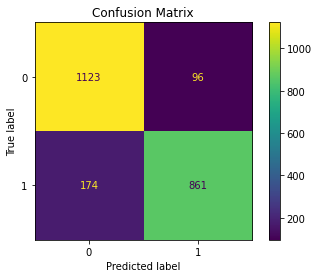

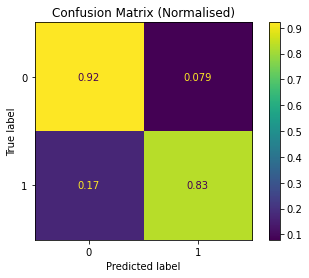

In [183]:
ConfusionMatrixMetrics(TestDataLoader.classes,PredsB4_B)

In [184]:
acc_B4_B =  accuracy_score(TestDataLoader.classes,PredsB4_B)

print(f'The model has an accuracy of {(acc_B4_B*100):.2f}%')

The model has an accuracy of 88.02%


In [185]:
print(classification_report(TestDataLoader.classes, PredsB4_B, target_names=Classes))

              precision    recall  f1-score   support

     Organic       0.87      0.92      0.89      1219
  Recyclable       0.90      0.83      0.86      1035

    accuracy                           0.88      2254
   macro avg       0.88      0.88      0.88      2254
weighted avg       0.88      0.88      0.88      2254



In [ ]:
f1_B4_B = 0.88

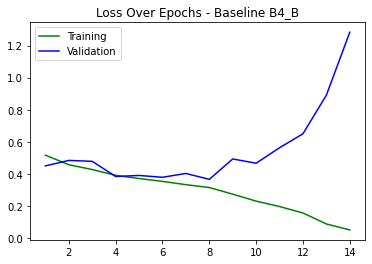

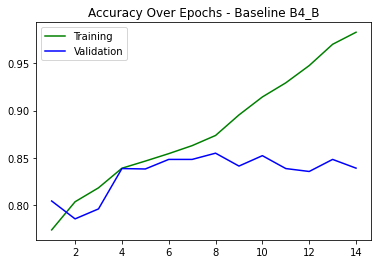

In [186]:
PlotHistory(hist,"Baseline B4_B")

**The model Baseline B4 B has achieved an accuracy of 88.02% with an F-score of 0.88**


### B4 Analysis <a class="anchor" id="b4analysis"></a>

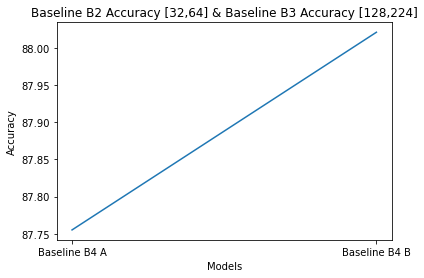

In [199]:
plt.plot(['Baseline B4 A','Baseline B4 B'],[acc_B4_A*100,acc_B4_B*100])
plt.title("Baseline B2 Accuracy [32,64] & Baseline B3 Accuracy [128,224]")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.show()


From the above plot, we can see that Centering and standardisation is performing well than then normal rescaling. Hence, we will use this data normalisation technique in our further experiments



## Baseline B5 <a class="anchor" id="b5"></a>
**Data Augmentation**
Previously, We have experimented with adding more layers, increasing the image size and data normalisation techniques.

Now, we experiment with various data augmentation techniques, to see how it impacts the performance of the model

These image augmentation techniques not only expand the size of our dataset but also incorporate a level of variation in the dataset which allows our model to generalize better on unseen data. Also, the model becomes more robust when it is trained on new, slightly altered/augmented images.

## Baseline B5 A <a class="anchor" id="b4a"></a>

In [13]:
InputSize = [224,224]
InputChannels = [3]
InputShape = InputSize + InputChannels

In [14]:
from pathlib import Path

#Loading all images
height,width = InputSize

def read_pil_image(img_path, height, width):
        with open(img_path, 'rb') as f:
            return np.array(Image.open(f).convert('RGB').resize((width, height)))

def load_all_images(dataset_path, height, width, img_ext='jpg'):
    return np.array([read_pil_image(str(p), height, width) for p in Path(dataset_path).rglob("*."+img_ext)]) 



In [15]:
#We will use data augmentation only while training
TrainDataGenerator = ImageDataGenerator(rescale=1./255, featurewise_center=True, featurewise_std_normalization=True,rotation_range=30, fill_mode='nearest',width_shift_range=0.2, height_shift_range=0.2,horizontal_flip=True, vertical_flip=True,brightness_range=[0.4,1.5],zoom_range=0.3,)

ValDataGenerator = ImageDataGenerator(rescale=1./255, featurewise_center=True, featurewise_std_normalization=True,)
TestDataGenerator = ImageDataGenerator(rescale = 1./255, featurewise_center=True, featurewise_std_normalization=True,)

#Load all images

ImagesClassOrganic = load_all_images("Data/TRAIN/Organic",height,width)
ImagesClassRecyclable = load_all_images("Data/TRAIN/Recyclable",height,width)
TrainImages = np.vstack((ImagesClassOrganic,ImagesClassRecyclable))


#Computing statistics on train images, to use them to center and standardise train, val and test data
TrainDataGenerator.fit(TrainImages)
ValDataGenerator.fit(TrainImages)
TestDataGenerator.fit(TrainImages)


#Using statistics to center and standardise data during training and testing
TrainDataLoader = TrainDataGenerator.flow_from_directory(TRAIN_PATH,
                                                 target_size = InputSize,
                                                 batch_size = 16,
                                                 class_mode = 'categorical',)

ValDataLoader = ValDataGenerator.flow_from_directory(VAL_PATH,
                                                 target_size = InputSize,
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

TestDataLoader= TestDataGenerator.flow_from_directory(TEST_PATH,
                                            target_size = InputSize,
                                            batch_size = 16,
                                            class_mode = 'categorical',
                                            shuffle=False)




Found 10041 images belonging to 2 classes.
Found 2274 images belonging to 2 classes.
Found 2254 images belonging to 2 classes.


In [16]:
BaseLine_B5 = Sequential([
  Conv2D(32, kernel_size=5, activation='relu',input_shape=InputShape),
  MaxPooling2D(),
  Conv2D(64, kernel_size=5, activation='relu'),
  MaxPooling2D(),
  Conv2D(128, kernel_size=5, activation='relu'),
  MaxPooling2D(),
  Conv2D(256, kernel_size=5, activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(512, activation='relu'),
  Dense(256, activation='relu'),
  Dense(128, activation='relu'),
  Dense(Num_Classes, activation='softmax')
])

In [17]:
BaseLine_B5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 64)      51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 49, 49, 128)       204928    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 128)      0

In [18]:
BaseLine_B5.compile(
  loss='categorical_crossentropy',
 optimizer='adam',
  metrics=['accuracy']
)

In [19]:
hist = BaseLine_B5.fit_generator(
  TrainDataLoader,
  validation_data=ValDataLoader,
  epochs=30,
  steps_per_epoch=len(TrainDataLoader),
  validation_steps=len(ValDataLoader),
  callbacks = callbacks
)

Epoch 1/30
628/628 [==============================] - ETA: 0s - loss: 0.5534 - accuracy: 0.7590
Epoch 1: val_loss improved from inf to 0.53736, saving model to Checkpoints\BaseLine_B1.h5
628/628 [==============================] - 125s 181ms/step - loss: 0.5534 - accuracy: 0.7590 - val_loss: 0.5374 - val_accuracy: 0.7577 - lr: 0.0010
Epoch 2/30
628/628 [==============================] - ETA: 0s - loss: 0.6290 - accuracy: 0.7691
Epoch 2: val_loss did not improve from 0.53736
628/628 [==============================] - 96s 152ms/step - loss: 0.6290 - accuracy: 0.7691 - val_loss: 0.5921 - val_accuracy: 0.6961 - lr: 0.0010
Epoch 3/30
628/628 [==============================] - ETA: 0s - loss: 0.5192 - accuracy: 0.7671
Epoch 3: val_loss improved from 0.53736 to 0.47762, saving model to Checkpoints\BaseLine_B1.h5
628/628 [==============================] - 95s 152ms/step - loss: 0.5192 - accuracy: 0.7671 - val_loss: 0.4776 - val_accuracy: 0.7832 - lr: 0.0010
Epoch 4/30
628/628 [=================

In [20]:
PredsB5 = BaseLine_B5.predict_generator(TestDataLoader)
PredsB5 = np.argmax(PredsB5,axis=1)

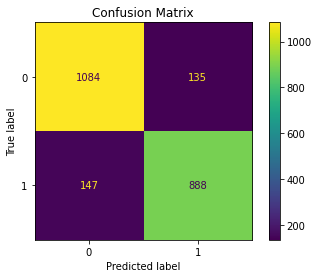

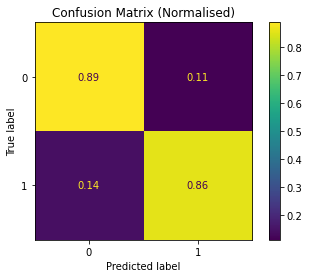

In [21]:
ConfusionMatrixMetrics(TestDataLoader.classes,PredsB5)

In [22]:
acc_B5 =  accuracy_score(TestDataLoader.classes,PredsB5)

print(f'The model has an accuracy of {(acc_B5*100):.2f}%')

The model has an accuracy of 87.49%


In [23]:
print(classification_report(TestDataLoader.classes, PredsB5, target_names=Classes))

              precision    recall  f1-score   support

     Organic       0.88      0.89      0.88      1219
  Recyclable       0.87      0.86      0.86      1035

    accuracy                           0.87      2254
   macro avg       0.87      0.87      0.87      2254
weighted avg       0.87      0.87      0.87      2254



In [24]:
f1_B5 = 0.87

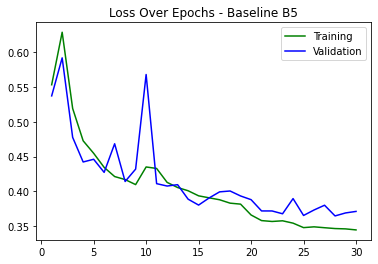

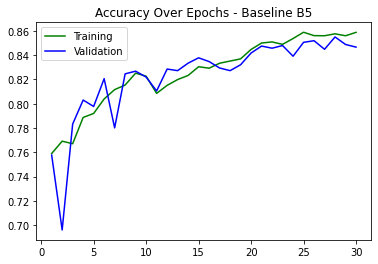

In [25]:
PlotHistory(hist,"Baseline B5")

**The model Baseline B5 A has achieved an accuracy of 87.49% with an F-score of 0.87**

This is a slight decrease in the performance. This can be caused because of the aggressive transforms/augmentations used. Aggressive augmentation makes the images too general to actually learn something. 

We will now try with less agressive augmentations

## Baseline B5 B <a class="anchor" id="b4b"></a>


In [13]:
InputSize = [224,224]
InputChannels = [3]
InputShape = InputSize + InputChannels

In [14]:
from pathlib import Path

#Loading all images
height,width = InputSize

def read_pil_image(img_path, height, width):
        with open(img_path, 'rb') as f:
            return np.array(Image.open(f).convert('RGB').resize((width, height)))

def load_all_images(dataset_path, height, width, img_ext='jpg'):
    return np.array([read_pil_image(str(p), height, width) for p in Path(dataset_path).rglob("*."+img_ext)]) 



In [29]:
#We will use data augmentation only while training
#The previous data augumentation might have been too agressive for the model to significantly learn anything
#We now test a less agressive data augmentation technique
TrainDataGenerator = ImageDataGenerator(rescale=1./255, 
                                featurewise_center=True, 
                                featurewise_std_normalization=True,
                                rotation_range=15, 
                                fill_mode='nearest',
                                width_shift_range=0.1, 
                                height_shift_range=0.1,
                                horizontal_flip=False, 
                                vertical_flip=False,
                                zoom_range=0.14,)

ValDataGenerator = ImageDataGenerator(rescale=1./255, featurewise_center=True, featurewise_std_normalization=True,)
TestDataGenerator = ImageDataGenerator(rescale = 1./255, featurewise_center=True, featurewise_std_normalization=True,)

#Load all images

ImagesClassOrganic = load_all_images("Data/TRAIN/Organic",height,width)
ImagesClassRecyclable = load_all_images("Data/TRAIN/Recyclable",height,width)
TrainImages = np.vstack((ImagesClassOrganic,ImagesClassRecyclable))


#Computing statistics on train images, to use them to center and standardise train, val and test data
TrainDataGenerator.fit(TrainImages)
ValDataGenerator.fit(TrainImages)
TestDataGenerator.fit(TrainImages)


#Using statistics to center and standardise data during training and testing
TrainDataLoader = TrainDataGenerator.flow_from_directory(TRAIN_PATH,
                                                 target_size = InputSize,
                                                 batch_size = 16,
                                                 class_mode = 'categorical',)

ValDataLoader = ValDataGenerator.flow_from_directory(VAL_PATH,
                                                 target_size = InputSize,
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

TestDataLoader= TestDataGenerator.flow_from_directory(TEST_PATH,
                                            target_size = InputSize,
                                            batch_size = 16,
                                            class_mode = 'categorical',
                                            shuffle=False)




Found 10041 images belonging to 2 classes.
Found 2274 images belonging to 2 classes.
Found 2254 images belonging to 2 classes.


In [30]:
BaseLine_B5_B = Sequential([
  Conv2D(32, kernel_size=5, activation='relu',input_shape=InputShape),
  MaxPooling2D(),
  Conv2D(64, kernel_size=5, activation='relu'),
  MaxPooling2D(),
  Conv2D(128, kernel_size=5, activation='relu'),
  MaxPooling2D(),
  Conv2D(256, kernel_size=5, activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(512, activation='relu'),
  Dense(256, activation='relu'),
  Dense(128, activation='relu'),
  Dense(Num_Classes, activation='softmax')
])

In [31]:
BaseLine_B5_B.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 220, 220, 32)      2432      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 110, 110, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 106, 106, 64)      51264     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 53, 53, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 49, 49, 128)       204928    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 128)     

In [32]:
BaseLine_B5_B.compile(
  loss='categorical_crossentropy',
 optimizer='adam',
  metrics=['accuracy']
)

In [33]:
hist = BaseLine_B5_B.fit_generator(
  TrainDataLoader,
  validation_data=ValDataLoader,
  epochs=30,
  steps_per_epoch=len(TrainDataLoader),
  validation_steps=len(ValDataLoader),
  callbacks = callbacks
)

Epoch 1/30
628/628 [==============================] - ETA: 0s - loss: 0.5310 - accuracy: 0.7741
Epoch 1: val_loss did not improve from 0.36446
628/628 [==============================] - 86s 136ms/step - loss: 0.5310 - accuracy: 0.7741 - val_loss: 0.4586 - val_accuracy: 0.7902 - lr: 0.0010
Epoch 2/30
628/628 [==============================] - ETA: 0s - loss: 0.4585 - accuracy: 0.8003
Epoch 2: val_loss did not improve from 0.36446
628/628 [==============================] - 75s 119ms/step - loss: 0.4585 - accuracy: 0.8003 - val_loss: 0.4939 - val_accuracy: 0.8056 - lr: 0.0010
Epoch 3/30
628/628 [==============================] - ETA: 0s - loss: 0.4466 - accuracy: 0.8070
Epoch 3: val_loss did not improve from 0.36446
628/628 [==============================] - 76s 121ms/step - loss: 0.4466 - accuracy: 0.8070 - val_loss: 0.4584 - val_accuracy: 0.7982 - lr: 0.0010
Epoch 4/30
628/628 [==============================] - ETA: 0s - loss: 0.4228 - accuracy: 0.8178
Epoch 4: val_loss did not improve 

In [34]:
PredsB5_B = BaseLine_B5_B.predict_generator(TestDataLoader) 
PredsB5_B = np.argmax(PredsB5_B,axis=1)

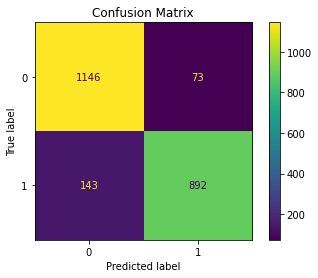

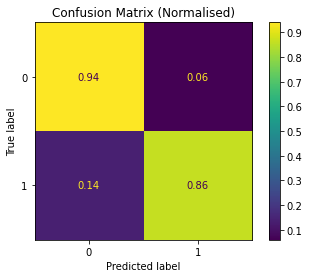

In [35]:
ConfusionMatrixMetrics(TestDataLoader.classes,PredsB5_B)

In [36]:
acc_B5_B =  accuracy_score(TestDataLoader.classes,PredsB5_B)

print(f'The model has an accuracy of {(acc_B5_B*100):.2f}%')

The model has an accuracy of 90.42%


This is the first time we have crossed 90% accuracy and also an fscore of 0.90

In [37]:
print(classification_report(TestDataLoader.classes, PredsB5_B, target_names=Classes))

              precision    recall  f1-score   support

     Organic       0.89      0.94      0.91      1219
  Recyclable       0.92      0.86      0.89      1035

    accuracy                           0.90      2254
   macro avg       0.91      0.90      0.90      2254
weighted avg       0.91      0.90      0.90      2254



In [38]:
f1_B5_B = 0.90

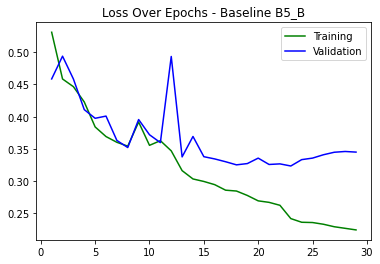

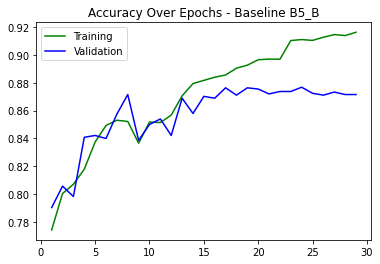

In [39]:
PlotHistory(hist,"Baseline B5_B")

**The model Baseline B5 B has achieved an accuracy of 90.42% with an F-score of 0.90**

This is the first time, we have crossed the accuracy level of 90%, in our experiments

As we can see, data augmenation mprived the accuracy, but the training times have gone significantly up. Using batch normalisations, the training times can be made faster

### B5 Analysis <a class="anchor" id="b4analysis"></a>

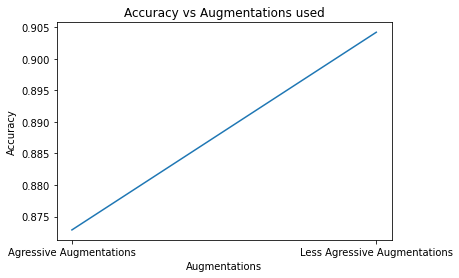

In [41]:
plt.plot(['Agressive Augmentations','Less Agressive Augmentations'],[acc_B5_A,acc_B5_B])
plt.title('Accuracy vs Augmentations used')
plt.xlabel("Augmentations")
plt.ylabel("Accuracy")
plt.show()

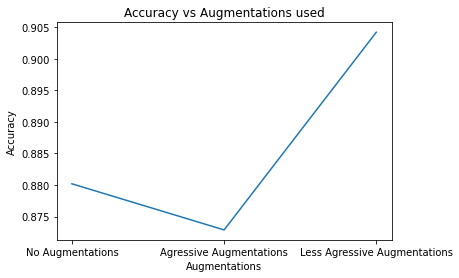

In [42]:
plt.plot(['No Augmentations','Agressive Augmentations','Less Agressive Augmentations'],[acc_B4_B,acc_B5_A,acc_B5_B])
plt.title('Accuracy vs Augmentations used')
plt.xlabel("Augmentations")
plt.ylabel("Accuracy")
plt.show()

From the plots, we can see that, right amount of data augmentations increases the performance of the model.

We have arrived at these data augmentations, after extensive experimentations with various data augmentations on our dataset. We will use these augmentations for our further tests

____

## Baseline B6 <a class="anchor" id="b6"></a>
**Batch Normalisations**

Batch normalisations helps in making the neural networks faster and more stable by normalising the layers inputs by re-centering and re-scaling them.

We now, test the effect of using batch normalisations on the performance of the model

In [21]:
InputSize = [224,224]
InputChannels = [3]
InputShape = InputSize + InputChannels

In [17]:


TrainDataGenerator = ImageDataGenerator(rescale=1./255, 
                                featurewise_center=True, 
                                featurewise_std_normalization=True,
                                rotation_range=15, 
                                fill_mode='nearest',
                                width_shift_range=0.1, 
                                height_shift_range=0.1,
                                horizontal_flip=False, 
                                vertical_flip=False,
                                zoom_range=0.14,)

ValDataGenerator = ImageDataGenerator(rescale=1./255, featurewise_center=True, featurewise_std_normalization=True,)
TestDataGenerator = ImageDataGenerator(rescale = 1./255, featurewise_center=True, featurewise_std_normalization=True,)



ImagesClassOrganic = load_all_images("Data/TRAIN/Organic",height,width)
ImagesClassRecyclable = load_all_images("Data/TRAIN/Recyclable",height,width)
TrainImages = np.vstack((ImagesClassOrganic,ImagesClassRecyclable))



TrainDataGenerator.fit(TrainImages)
ValDataGenerator.fit(TrainImages)
TestDataGenerator.fit(TrainImages)


TrainDataLoader = TrainDataGenerator.flow_from_directory(TRAIN_PATH,
                                                 target_size = InputSize,
                                                 batch_size = 16,
                                                 class_mode = 'categorical',)

ValDataLoader = ValDataGenerator.flow_from_directory(VAL_PATH,
                                                 target_size = InputSize,
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

TestDataLoader= TestDataGenerator.flow_from_directory(TEST_PATH,
                                            target_size = InputSize,
                                            batch_size = 16,
                                            class_mode = 'categorical',
                                            shuffle=False)




Found 10041 images belonging to 2 classes.
Found 2274 images belonging to 2 classes.
Found 2254 images belonging to 2 classes.


In [22]:
BaseLine_B6 = Sequential([
  Conv2D(32, kernel_size=5, activation='relu',input_shape=InputShape),
  BatchNormalization(),
  MaxPooling2D(),
  Conv2D(64, kernel_size=5, activation='relu'),
  BatchNormalization(),
  MaxPooling2D(),
  Conv2D(128, kernel_size=5, activation='relu'),
  BatchNormalization(),
  MaxPooling2D(),
  Conv2D(256, kernel_size=5, activation='relu'),
  BatchNormalization(),
  MaxPooling2D(),
  Flatten(),
  Dense(512, activation='relu'),
  BatchNormalization(),
  Dense(256, activation='relu'),
  BatchNormalization(),
  Dense(128, activation='relu'),
  BatchNormalization(),
  Dense(Num_Classes, activation='softmax')
])



In [23]:
BaseLine_B6.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 220, 220, 32)      2432      
                                                                 
 batch_normalization_14 (Bat  (None, 220, 220, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 110, 110, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 106, 106, 64)      51264     
                                                                 
 batch_normalization_15 (Bat  (None, 106, 106, 64)     256       
 chNormalization)                                                
                                                      

In [24]:
BaseLine_B6.compile(
  loss='categorical_crossentropy',
 optimizer='adam',
  metrics=['accuracy']
)

In [25]:
hist = BaseLine_B6.fit_generator(
  TrainDataLoader,
  validation_data=ValDataLoader,
  epochs=30,
  steps_per_epoch=len(TrainDataLoader),
  validation_steps=len(ValDataLoader),
  callbacks = callbacks
)

Epoch 1/30
628/628 [==============================] - ETA: 0s - loss: 0.4897 - accuracy: 0.7822
Epoch 1: val_loss improved from inf to 0.57045, saving model to Checkpoints\BaseLine_B1.h5
628/628 [==============================] - 97s 140ms/step - loss: 0.4897 - accuracy: 0.7822 - val_loss: 0.5705 - val_accuracy: 0.7155 - lr: 0.0010
Epoch 2/30
628/628 [==============================] - ETA: 0s - loss: 0.4367 - accuracy: 0.8114
Epoch 2: val_loss improved from 0.57045 to 0.49796, saving model to Checkpoints\BaseLine_B1.h5
628/628 [==============================] - 78s 124ms/step - loss: 0.4367 - accuracy: 0.8114 - val_loss: 0.4980 - val_accuracy: 0.7634 - lr: 0.0010
Epoch 3/30
628/628 [==============================] - ETA: 0s - loss: 0.4221 - accuracy: 0.8134
Epoch 3: val_loss improved from 0.49796 to 0.41243, saving model to Checkpoints\BaseLine_B1.h5
628/628 [==============================] - 78s 125ms/step - loss: 0.4221 - accuracy: 0.8134 - val_loss: 0.4124 - val_accuracy: 0.8263 - l

In [26]:
PredsB6 = BaseLine_B6.predict_generator(TestDataLoader)
PredsB6 = np.argmax(PredsB6,axis=1)

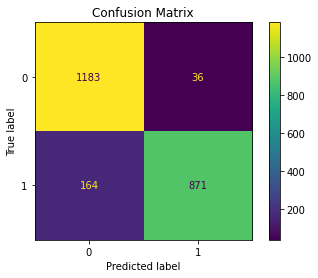

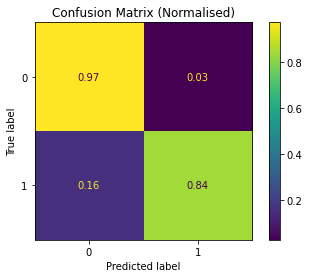

In [27]:
ConfusionMatrixMetrics(TestDataLoader.classes,PredsB6)

In [28]:
acc_B6 =  accuracy_score(TestDataLoader.classes,PredsB6)

print(f'The model has an accuracy of {(acc_B6*100):.2f}%')

The model has an accuracy of 91.13%


In [29]:
print(classification_report(TestDataLoader.classes, PredsB6, target_names=Classes))

              precision    recall  f1-score   support

     Organic       0.88      0.97      0.92      1219
  Recyclable       0.96      0.84      0.90      1035

    accuracy                           0.91      2254
   macro avg       0.92      0.91      0.91      2254
weighted avg       0.92      0.91      0.91      2254



In [30]:
f1_B6 = 0.91

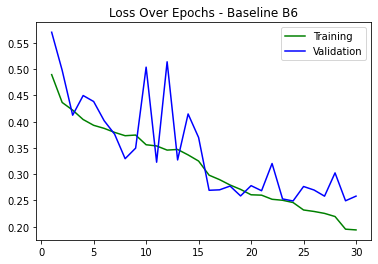

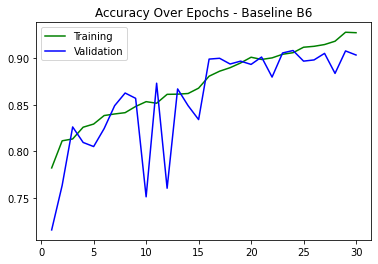

In [31]:
PlotHistory(hist,"Baseline B6")

**The model Baseline B6 has achieved an accuracy of 91.13% with an F-score of 0.91**

Using batch normalisations has increased the performance of the model

## Baseline B7 <a class="anchor" id="b7"></a>
**Dropouts**

Dropout regularisation helps us prevent overfitting of the Neural Network model on the dataset. This is done by randomly dropping certain portion of nodes in the neural network, thus forcing all neurons to learn some information.

In [10]:
InputSize = [224,224]
InputChannels = [3]
InputShape = InputSize + InputChannels

In [13]:

TrainDataGenerator = ImageDataGenerator(rescale=1./255, 
                                featurewise_center=True, 
                                featurewise_std_normalization=True,
                                rotation_range=15, 
                                fill_mode='nearest',
                                width_shift_range=0.1, 
                                height_shift_range=0.1,
                                horizontal_flip=False, 
                                vertical_flip=False,
                                zoom_range=0.14,)

ValDataGenerator = ImageDataGenerator(rescale=1./255, featurewise_center=True, featurewise_std_normalization=True,)
TestDataGenerator = ImageDataGenerator(rescale = 1./255, featurewise_center=True, featurewise_std_normalization=True,)



ImagesClassOrganic = load_all_images("Data/TRAIN/Organic",height,width)
ImagesClassRecyclable = load_all_images("Data/TRAIN/Recyclable",height,width)
TrainImages = np.vstack((ImagesClassOrganic,ImagesClassRecyclable))


TrainDataGenerator.fit(TrainImages)
ValDataGenerator.fit(TrainImages)
TestDataGenerator.fit(TrainImages)


#Using statistics to center and standardise data during training and testing
TrainDataLoader = TrainDataGenerator.flow_from_directory(TRAIN_PATH,
                                                 target_size = InputSize,
                                                 batch_size = 16,
                                                 class_mode = 'categorical',)

ValDataLoader = ValDataGenerator.flow_from_directory(VAL_PATH,
                                                 target_size = InputSize,
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

TestDataLoader= TestDataGenerator.flow_from_directory(TEST_PATH,
                                            target_size = InputSize,
                                            batch_size = 16,
                                            class_mode = 'categorical',
                                            shuffle=False)




Found 10041 images belonging to 2 classes.
Found 2274 images belonging to 2 classes.
Found 2254 images belonging to 2 classes.


In [14]:
BaseLine_B7 = Sequential([
  Conv2D(32, kernel_size=5, activation='relu',input_shape=InputShape),
  BatchNormalization(),
  MaxPooling2D(),
  Conv2D(64, kernel_size=5, activation='relu'),
  BatchNormalization(),
  MaxPooling2D(),
  Conv2D(128, kernel_size=5, activation='relu'),
  BatchNormalization(),
  MaxPooling2D(),
  Conv2D(256, kernel_size=5, activation='relu'),
  BatchNormalization(),
  MaxPooling2D(),
  Flatten(),
  Dense(512, activation='relu'),
  BatchNormalization(),
  Dropout(0.17),
  Dense(256, activation='relu'),
  BatchNormalization(),
  Dropout(0.17),
  Dense(128, activation='relu'),
  BatchNormalization(),
  Dropout(0.17),
  Dense(Num_Classes, activation='softmax')
])



In [15]:
BaseLine_B7.compile(
  loss='categorical_crossentropy',
 optimizer='adam',
  metrics=['accuracy']
)

In [16]:
hist = BaseLine_B7.fit_generator(
  TrainDataLoader,
  validation_data=ValDataLoader,
  epochs=30,
  steps_per_epoch=len(TrainDataLoader),
  validation_steps=len(ValDataLoader),
  callbacks = callbacks
)

Epoch 1/30
628/628 [==============================] - ETA: 0s - loss: 0.5251 - accuracy: 0.7680
Epoch 1: val_loss improved from inf to 0.44504, saving model to Checkpoints\BaseLine_B1.h5
628/628 [==============================] - 102s 146ms/step - loss: 0.5251 - accuracy: 0.7680 - val_loss: 0.4450 - val_accuracy: 0.8105 - lr: 0.0010
Epoch 2/30
628/628 [==============================] - ETA: 0s - loss: 0.4681 - accuracy: 0.7967
Epoch 2: val_loss did not improve from 0.44504
628/628 [==============================] - 70s 111ms/step - loss: 0.4681 - accuracy: 0.7967 - val_loss: 0.5481 - val_accuracy: 0.7735 - lr: 0.0010
Epoch 3/30
628/628 [==============================] - ETA: 0s - loss: 0.4299 - accuracy: 0.8135
Epoch 3: val_loss did not improve from 0.44504
628/628 [==============================] - 69s 110ms/step - loss: 0.4299 - accuracy: 0.8135 - val_loss: 0.4571 - val_accuracy: 0.7806 - lr: 0.0010
Epoch 4/30
628/628 [==============================] - ETA: 0s - loss: 0.4149 - accura

Epoch 27/30
628/628 [==============================] - ETA: 0s - loss: 0.2241 - accuracy: 0.9110
Epoch 27: val_loss did not improve from 0.24943
628/628 [==============================] - 75s 120ms/step - loss: 0.2241 - accuracy: 0.9110 - val_loss: 0.2595 - val_accuracy: 0.9028 - lr: 4.0000e-05
Epoch 28/30
628/628 [==============================] - ETA: 0s - loss: 0.2241 - accuracy: 0.9128
Epoch 28: val_loss did not improve from 0.24943
628/628 [==============================] - 76s 121ms/step - loss: 0.2241 - accuracy: 0.9128 - val_loss: 0.2628 - val_accuracy: 0.9011 - lr: 4.0000e-05
Epoch 29/30
628/628 [==============================] - ETA: 0s - loss: 0.2207 - accuracy: 0.9169
Epoch 29: val_loss did not improve from 0.24943
628/628 [==============================] - 75s 120ms/step - loss: 0.2207 - accuracy: 0.9169 - val_loss: 0.2715 - val_accuracy: 0.8993 - lr: 4.0000e-05
Epoch 30/30
628/628 [==============================] - ETA: 0s - loss: 0.2187 - accuracy: 0.9167
Epoch 30: val_l

In [17]:
PredsB7 = BaseLine_B7.predict_generator(TestDataLoader)
PredsB7 = np.argmax(PredsB7,axis=1)

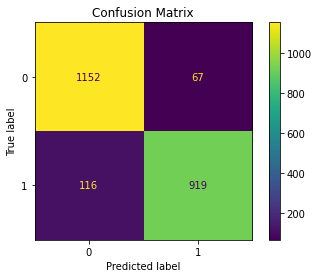

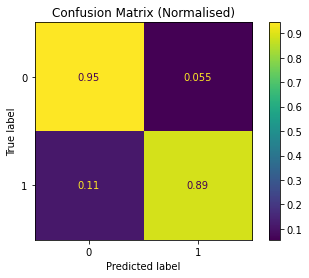

In [18]:
ConfusionMatrixMetrics(TestDataLoader.classes,PredsB7)

In [19]:
acc_B7 =  accuracy_score(TestDataLoader.classes,PredsB7)

print(f'The model has an accuracy of {(acc_B7*100):.2f}%')

The model has an accuracy of 91.88%


In [20]:
print(classification_report(TestDataLoader.classes, PredsB7, target_names=Classes))

              precision    recall  f1-score   support

     Organic       0.91      0.95      0.93      1219
  Recyclable       0.93      0.89      0.91      1035

    accuracy                           0.92      2254
   macro avg       0.92      0.92      0.92      2254
weighted avg       0.92      0.92      0.92      2254



In [23]:
f1_B7 = 0.92

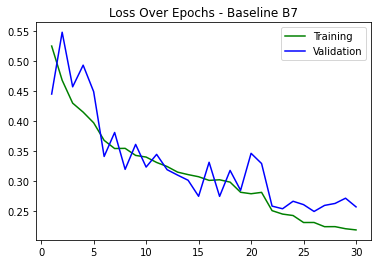

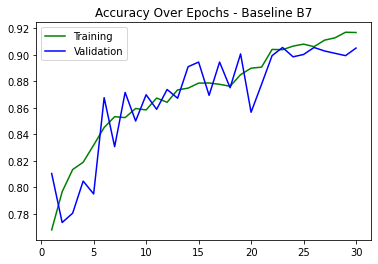

In [24]:
PlotHistory(hist,"Baseline B7")

**The model Baseline B7 has achieved an accuracy of 91.88% with an F-score of 0.92**


## Analysis of Baseline Models <a class="anchor" id="baselineanalysis"></a>

##### The following table summarises the accuracies and F-scores of the models

| Experiment | Experiment | Accuracy % | F-Score |
| --- | --- | --- | --- |
| Baseline B1 | Base Model | 84.74% | 0.84 |
| Baseline B2 32 | Image Size 32 | 84.74% | 0.84 |
| Baseline B2 64 | Image Size 64 | 86.56% | 0.86 |
| Baseline B2 128 | Image Size 128 | 83.14% | 0.83 |
| Baseline B2 224 | Image Size 224 | 80.83% | 0.81 |
| Baseline B3 128 | Deeper Network | 88.46% | 0.88 |
| Baseline B3 224 | Deeper Network | 89.22% | 0.89 |
| Baseline B4 A | Pixel Normalization | 87.76% | 0.88 |
| Baseline B4 B | Centering & Standardizing | 88.02% | 0.88 |
| Baseline B5 A | Aggressive Data Augmentations | 87.29% | 0.87 |
| Baseline B5 B | Less aggressive Data Augmentations | 90.42% | 0.90 |
| Baseline B6 | Batch Normalisations | 91.13% | 0.91 |
| Baseline B7 | Dropouts | 91.88% | 0.92 |

##### Lets check how accuracy changed during all the steps. 

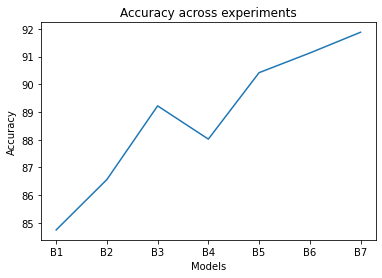

B1 -Baseline B2 -Bigger Image Sizes B3 -Adding More Layers B4 -Data Normalisation 
 B5 -Data Augmentation B6- Batch Norms B7- Dropouts


In [26]:
y = [acc_B1*100,acc_B2_64*100,acc_B3_224*100,acc_B4_B*100,acc_B5_B*100,acc_B6*100,acc_B7*100]
# x = ["Baseline","Bigger Image Sizes","Adding More Layers","Data Normalisation","Data Augmentation","Batch Norms","Dropouts",]
x = ["B1","B2","B3","B4","B5","B6","B7"]

plt.plot(x,y)
plt.title("Accuracy across experiments")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.show()

print("B1 -Baseline","B2 -Bigger Image Sizes","B3 -Adding More Layers","B4 -Data Normalisation","\n","B5 -Data Augmentation","B6- Batch Norms","B7- Dropouts")

##### Effect of increasing image size on the performance of the model

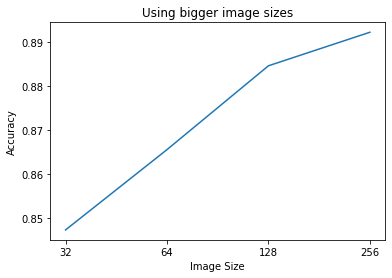

In [56]:
plt.plot(['32','64','128','256'],[acc_B2_32, acc_B2_64, acc_B3_128, acc_B3_224])
plt.title("Using bigger image sizes")
plt.xlabel("Image Size")
plt.ylabel("Accuracy")
plt.show()

##### Effect of using different normalisation techniques

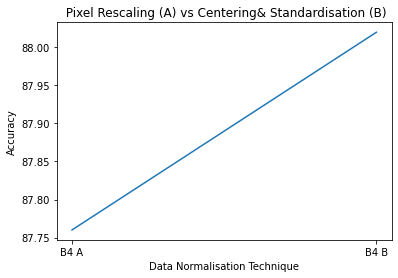

In [53]:
plt.plot(['B4 A','B4 B'],[acc_B4_A*100,acc_B4_B*100])
plt.title(" Pixel Rescaling (A) vs Centering& Standardisation (B)")
plt.xlabel("Data Normalisation Technique")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
##### Effect of using different Data Augmentation techniques

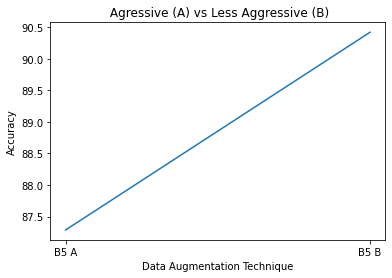

In [55]:
plt.plot(['B5 A','B5 B'],[acc_B5*100,acc_B5_B*100])
plt.title(" Agressive (A) vs Less Aggressive (B)")
plt.xlabel("Data Augmentation Techniques")
plt.ylabel("Accuracy")
plt.show()

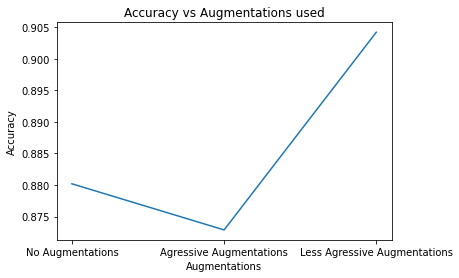

In [43]:
plt.plot(['No Augmentations','Agressive Augmentations','Less Agressive Augmentations'],[acc_B4_B,acc_B5_A,acc_B5_B])
plt.title('Accuracy vs Augmentations used')
plt.xlabel("Augmentations")
plt.ylabel("Accuracy")
plt.show()

**Summary**

Adding more layers and making the model more deep has improved the performance of the model (B3)
Increasing the size of Input Image Size has improved the performance of the model (B3 & B2)
Centering and standarsisation of inputs has improved the performance of the model (B4)
Data Augmentations have improved the performance, but aggressive augmentations have decreased the performance. A sweet spot has been found by experimenting with various Data Augmentation techniques (B5)
Batch Normalisations and Dropouts have also improved the performance of the model (B6 & B7)
We will use these learnings in while adapting the pretrained ResNet50 model to our data.


_________________________


## Transfer learning from pre-trained CNN Models <a class="anchor" id="transferlearning"></a>

### Overview <a class="anchor" id="transferlearningoverview"></a>
In the previous experiments, we have built the models from scratch, initialised the model parameters and trained the model to fine tune the model parameters to increase the model performance. We have also used various techniques like Data Normalisation, Data Augmentations, Batch Normalisations & Dropouts to improve the performance of the model.

Now, we use pretrained models (i.e, CNN models trained on certain data for a certain task). We use a technique called transfer learning, to adapt the pretrained models to our data for our task

### Transfer Learning <a class="anchor" id="transferlearningintro"></a>

Transfer Learning is a process where a model trained on one problem is used in some other task on a second, related problem. For eg. A model trained on classifying cats & dogs can be adapted to identify different kinds of cats and dogs.

Transfer Learning is advantageous for a number of reasons. It already has useful learned feature representations, the models trained on huge datasets have already learned how to detect generic features from photographs, as they have been trained on 1,000,000 images for around 1000 images

The models have achieved state of the art performance, there is no point in spending such a high computation cost to train them again from scratch

These models are easily accessible and can be tweaked to our liking with ease


Different types of transfer learning

**Using the pretrained models as classifier**
We use the pretrained model as it is. We only change the output/exit layer (that maps final dense layer to number of classes)
**Using the pretrained model as standalone feature exctractor**
We use only the convulution blocks of the pretrained layer. We remove a couple or all dense layers. We use the CNN model without these dense layers, as a feature extractor. We build a small neural network/ fully connected layers on top of this feature extractor, whoch will act as classifier. We freeze all the layers of the CNN model, and only train the neural network on the top.
**Fine tuning the pre trained model**
Once the model from previous step has achieved significant performance, we take the model, unfreeze all the layers from CNN model (including the convolution blocks of pre trained model). We use a very very small learning rate and train the entire model on our dataset, to adapt the pretrained model to our data

## ResNet50 <a class="anchor" id="resnet50overview"></a>

ResNet-50 is a CNN model thatt is 50 layers deep, the network is trained on more than a million images from ImageNet database belonging to over 1000 images. The network has learnt a rich fature representations for a images belonging to a wide range of different classes. The network takes an inout at size 224x224. ResNets solved a main challenge in deep neural networks called as vanishing gradient problem. The residual connections allow the network to solve the vanishing gradient porblem and thus helps in building and training very deep neural networks

We will the pretrained ResNet50 CNN model for transfer learning


### ResNet50 R1 A <a class="anchor" id="r1a"></a>

**Using the pretrained models as classifier**

We use the Resnet50 as it is, with ImageNet weights, we only change the output layer. 


In [42]:
InputSize = [224,224]
InputChannels = [3]
InputShape = InputSize + InputChannels

In [65]:

checkpoint = ModelCheckpoint("Checkpoints/Resnet_R1_A.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0.0001, 
                          patience = 6,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 4,
                              verbose = 1,
                              min_delta = 0.0001)

callbacks = [earlystop, checkpoint, reduce_lr]

In [66]:


TrainDataGenerator = ImageDataGenerator(preprocessing_function=preprocess_input)

TrainDataLoader = TrainDataGenerator.flow_from_directory(TRAIN_PATH,
                                                  target_size=InputSize,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=16)

ValDataGenerator = ImageDataGenerator(preprocessing_function=preprocess_input)
ValDataLoader = ValDataGenerator.flow_from_directory(VAL_PATH,
                                                  target_size=InputSize,
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=16)


TestDataGenerator = ImageDataGenerator(preprocessing_function=preprocess_input)
TestDataLoader = TestDataGenerator.flow_from_directory(VAL_PATH,
                                                  target_size=InputSize,
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=16)                                                 

Found 10041 images belonging to 2 classes.
Found 2274 images belonging to 2 classes.
Found 2274 images belonging to 2 classes.


In [68]:
#Loading the resnet50 model with imagenet weights
resnet_R1= ResNet50( include_top = True,weights="imagenet")
# resnet_R1.summary()

#Freezing all the layers in the pretrained model
for layer in resnet_R1.layers:
  layer.trainable = False

#Deleting the output/exit layer
x = (resnet_R1.layers[-2].output)

#Adding a new dense layer (output layer)
prediction = Dense(Num_Classes, activation='softmax')(x)

#Compiling the model with the new output/exit layer
resnet_R1_A = Model(inputs=resnet_R1.input, outputs=prediction)

In [69]:
#Model Summary
resnet_R1_A.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_11[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
resnet_R1_A 

In [70]:
resnet_R1_A.compile(
  loss='categorical_crossentropy',
 optimizer='adam',
  metrics=['accuracy']
)

In [71]:
hist = resnet_R1_A.fit_generator(
  TrainDataLoader,
  validation_data=ValDataLoader,
  epochs=30,
  steps_per_epoch=len(TrainDataLoader),
  validation_steps=len(ValDataLoader),
  callbacks = callbacks
)

Epoch 1/30
628/628 [==============================] - ETA: 0s - loss: 0.2033 - accuracy: 0.9239
Epoch 1: val_loss improved from inf to 0.22945, saving model to Checkpoints\Resnet_R1_A.h5
628/628 [==============================] - 70s 108ms/step - loss: 0.2033 - accuracy: 0.9239 - val_loss: 0.2295 - val_accuracy: 0.9182 - lr: 0.0010
Epoch 2/30
628/628 [==============================] - ETA: 0s - loss: 0.1404 - accuracy: 0.9510
Epoch 2: val_loss improved from 0.22945 to 0.14882, saving model to Checkpoints\Resnet_R1_A.h5
628/628 [==============================] - 68s 109ms/step - loss: 0.1404 - accuracy: 0.9510 - val_loss: 0.1488 - val_accuracy: 0.9442 - lr: 0.0010
Epoch 3/30
628/628 [==============================] - ETA: 0s - loss: 0.1220 - accuracy: 0.9566
Epoch 3: val_loss did not improve from 0.14882
628/628 [==============================] - 69s 110ms/step - loss: 0.1220 - accuracy: 0.9566 - val_loss: 0.1598 - val_accuracy: 0.9415 - lr: 0.0010
Epoch 4/30
628/628 [==================

In [72]:
PredsR1_A = resnet_R1_A.predict_generator(TestDataLoader) 
PredsR1_A = np.argmax(PredsR1_A,axis=1)

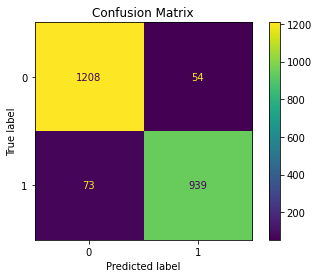

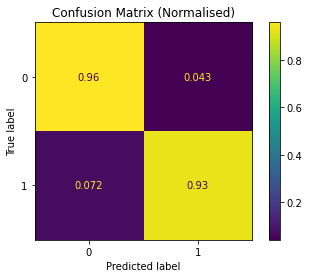

In [73]:
ConfusionMatrixMetrics(TestDataLoader.classes,PredsR1_A)

In [74]:
acc_R1_A =  accuracy_score(TestDataLoader.classes,PredsR1_A)

print(f'The model has an accuracy of {(acc_R1_A*100):.2f}%')

The model has an accuracy of 94.42%


In [75]:
print(classification_report(TestDataLoader.classes, PredsR1_A, target_names=Classes))

              precision    recall  f1-score   support

     Organic       0.94      0.96      0.95      1262
  Recyclable       0.95      0.93      0.94      1012

    accuracy                           0.94      2274
   macro avg       0.94      0.94      0.94      2274
weighted avg       0.94      0.94      0.94      2274



In [ ]:
f1_R1_A = 0.94

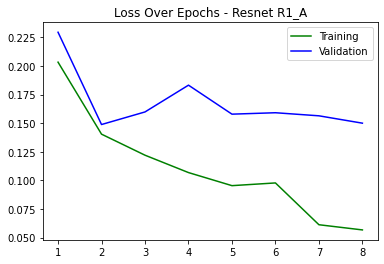

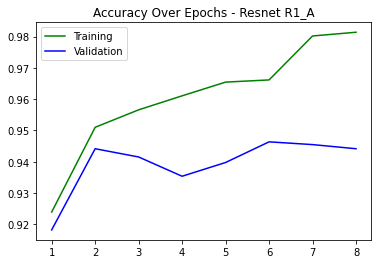

In [81]:
PlotHistory(hist,"Resnet R1_A")

**The model ResNet50 R1 A has achieved an accuracy of 94.42% with an F-score of 0.94**



_______

## ResNet50 R1 B <a class="anchor" id="r1b"></a>
From previous experiments, we have learnt that, Data Augmentations help increase the performance of the model. We use the same augmentations on ResNet50 R1 A model. 

In [77]:
InputSize = [224,224]
InputChannels = [3]
InputShape = InputSize + InputChannels

In [82]:
#We will use the same data augmentations as we have tried earlier
TrainDataGenerator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=15,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.14,
                                   horizontal_flip=False,
                                   vertical_flip=False,
                                   fill_mode='nearest')

TrainDataLoader = TrainDataGenerator.flow_from_directory(TRAIN_PATH,
                                                  target_size=InputSize,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=16)

ValDataGenerator = ImageDataGenerator(preprocessing_function=preprocess_input)
ValDataLoader = ValDataGenerator.flow_from_directory(VAL_PATH,
                                                  target_size=InputSize,
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=16)

TestDataGenerator = ImageDataGenerator(preprocessing_function=preprocess_input)
TestDataLoader = TestDataGenerator.flow_from_directory(VAL_PATH,
                                                  target_size=InputSize,
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=16)                                                 

Found 10041 images belonging to 2 classes.
Found 2274 images belonging to 2 classes.
Found 2274 images belonging to 2 classes.


In [83]:
#Loading the resnet50 model with imagenet weights
resnet_R1= ResNet50( include_top = True,weights="imagenet")
# resnet_R1.summary()

#Freezing all the layers
for layer in resnet_R1.layers:
  layer.trainable = False

#Deleting the output/exit layer
x = (resnet_R1.layers[-2].output)

#Adding a new dense layer
prediction = Dense(Num_Classes, activation='softmax')(x)

#Compiling the model with the new output/exit layer
resnet_R1_B = Model(inputs=resnet_R1.input, outputs=prediction)

In [84]:
resnet_R1_B.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_13[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [85]:
resnet_R1_B.compile(
  loss='categorical_crossentropy',
 optimizer='adam',
  metrics=['accuracy']
)

In [86]:
hist = resnet_R1_B.fit_generator(
  TrainDataLoader,
  validation_data=ValDataLoader,
  epochs=30,
  steps_per_epoch=len(TrainDataLoader),
  validation_steps=len(ValDataLoader),
  callbacks = callbacks
)

Epoch 1/30
628/628 [==============================] - ETA: 0s - loss: 0.2077 - accuracy: 0.9229
Epoch 1: val_loss did not improve from 0.14882
628/628 [==============================] - 92s 144ms/step - loss: 0.2077 - accuracy: 0.9229 - val_loss: 0.1552 - val_accuracy: 0.9420 - lr: 0.0010
Epoch 2/30
628/628 [==============================] - ETA: 0s - loss: 0.1660 - accuracy: 0.9383
Epoch 2: val_loss did not improve from 0.14882
628/628 [==============================] - 95s 151ms/step - loss: 0.1660 - accuracy: 0.9383 - val_loss: 0.1509 - val_accuracy: 0.9472 - lr: 0.0010
Epoch 3/30
628/628 [==============================] - ETA: 0s - loss: 0.1393 - accuracy: 0.9479
Epoch 3: val_loss improved from 0.14882 to 0.14428, saving model to Checkpoints\Resnet_R1_A.h5
628/628 [==============================] - 93s 148ms/step - loss: 0.1393 - accuracy: 0.9479 - val_loss: 0.1443 - val_accuracy: 0.9494 - lr: 0.0010
Epoch 4/30
628/628 [==============================] - ETA: 0s - loss: 0.1316 - acc

In [87]:
PredsR1_B = resnet_R1_B.predict_generator(TestDataLoader) 
PredsR1_B = np.argmax(PredsR1_B,axis=1)

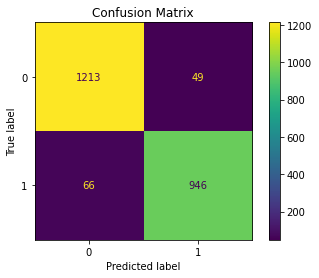

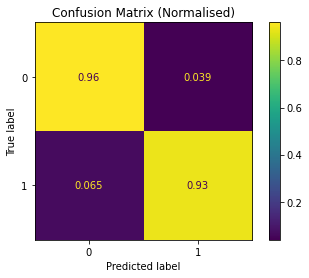

In [88]:
ConfusionMatrixMetrics(TestDataLoader.classes,PredsR1_B)

In [89]:
acc_R1_B =  accuracy_score(TestDataLoader.classes,PredsR1_B)

print(f'The model has an accuracy of {(acc_R1_B*100):.2f}%')

The model has an accuracy of 94.94%


In [90]:
print(classification_report(TestDataLoader.classes, PredsR1_B, target_names=Classes))

              precision    recall  f1-score   support

     Organic       0.95      0.96      0.95      1262
  Recyclable       0.95      0.93      0.94      1012

    accuracy                           0.95      2274
   macro avg       0.95      0.95      0.95      2274
weighted avg       0.95      0.95      0.95      2274



In [91]:
f1_R1_B = 0.95

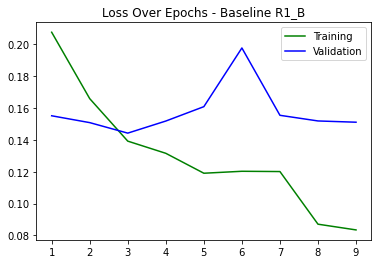

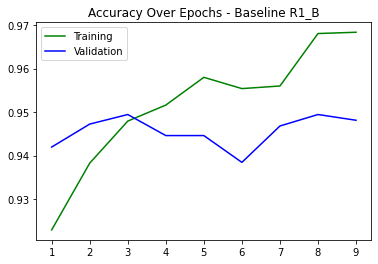

In [92]:
PlotHistory(hist,"Baseline R1_B")

**The model ResNet50 R1 B has achieved an accuracy of 94.94% with an F-score of 0.95**



_________

## ResNet50 R2 <a class="anchor" id="r2"></a>

**Using the pretrained model as standalone feature exctractor**

We use use pretrained ResNet50 (without the dense layers) as feature extractor. We use Baseline B7 mode on top of ResNet50 extractor, that acts as a classifier. 

In [11]:
InputSize = [224,224]
InputChannels = [3]
InputShape = InputSize + InputChannels

In [12]:
#We will use the same data augmentations as we have tried earlier
TrainDataGenerator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=15,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.14,
                                   horizontal_flip=False,
                                   vertical_flip=False,
                                   fill_mode='nearest')

TrainDataLoader = TrainDataGenerator.flow_from_directory(TRAIN_PATH,
                                                  target_size=InputSize,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=8)

ValDataGenerator = ImageDataGenerator(preprocessing_function=preprocess_input)
ValDataLoader = ValDataGenerator.flow_from_directory(VAL_PATH,
                                                  target_size=InputSize,
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=8)

TestDataGenerator = ImageDataGenerator(preprocessing_function=preprocess_input)
TestDataLoader = TestDataGenerator.flow_from_directory(VAL_PATH,
                                                  target_size=InputSize,
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=8)                                                 

Found 10041 images belonging to 2 classes.
Found 2274 images belonging to 2 classes.
Found 2274 images belonging to 2 classes.


In [13]:
#Loading the pretrained resNet50 model without the dense layers
resnet_R2= ResNet50( include_top = False,weights="imagenet", input_shape=InputShape)
# resnet.summary()

#Freezing all the layers of pretrained model
for layer in resnet_R2.layers:
  layer.trainable = False
# show trainable state of layers
# resnet.summary()

#Adding Baseline B7 on top of ResNet50
x = Flatten()(resnet_R2.output)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.17)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.17)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.17)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.17)(x)
prediction = Dense(Num_Classes, activation='softmax')(x)

#Compiling the Baseline B7 model on top of ResNet50 model
resnet_R2_A = Model(inputs=resnet_R2.input, outputs=prediction)
# resnet_model.summary()




In [14]:
resnet_R2.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [15]:
resnet_R2_A.compile(
  loss='categorical_crossentropy',
 optimizer='adam',
  metrics=['accuracy']
)

In [16]:
hist = resnet_R2_A.fit_generator(
  TrainDataLoader,
  validation_data=ValDataLoader,
  epochs=30,
  steps_per_epoch=len(TrainDataLoader),
  validation_steps=len(ValDataLoader),
  callbacks = callbacks
)

Epoch 1/30
1256/1256 [==============================] - ETA: 0s - loss: 0.3359 - accuracy: 0.8734
Epoch 1: val_loss improved from inf to 0.17655, saving model to Checkpoints\BaseLine_B1.h5
1256/1256 [==============================] - 97s 73ms/step - loss: 0.3359 - accuracy: 0.8734 - val_loss: 0.1766 - val_accuracy: 0.9292 - lr: 0.0010
Epoch 2/30
1256/1256 [==============================] - ETA: 0s - loss: 0.2371 - accuracy: 0.9110
Epoch 2: val_loss improved from 0.17655 to 0.15381, saving model to Checkpoints\BaseLine_B1.h5
1256/1256 [==============================] - 96s 77ms/step - loss: 0.2371 - accuracy: 0.9110 - val_loss: 0.1538 - val_accuracy: 0.9428 - lr: 0.0010
Epoch 3/30
1256/1256 [==============================] - ETA: 0s - loss: 0.2165 - accuracy: 0.9225
Epoch 3: val_loss improved from 0.15381 to 0.14646, saving model to Checkpoints\BaseLine_B1.h5
1256/1256 [==============================] - 97s 77ms/step - loss: 0.2165 - accuracy: 0.9225 - val_loss: 0.1465 - val_accuracy: 0

In [17]:
PredsR2_A = resnet_R2_A.predict_generator(TestDataLoader) 
PredsR2_A = np.argmax(PredsR2_A,axis=1)

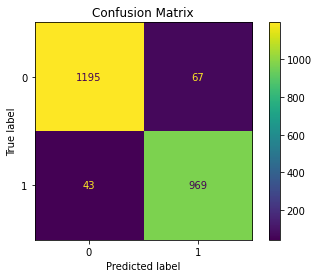

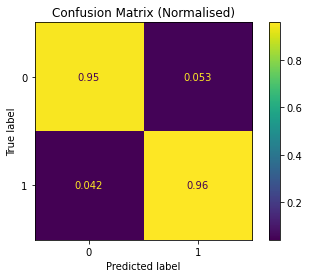

In [18]:
ConfusionMatrixMetrics(TestDataLoader.classes,PredsR2_A)

In [19]:
acc_R2_A =  accuracy_score(TestDataLoader.classes,PredsR2_A)

print(f'The model has an accuracy of {(acc_R2_A*100):.2f}%')

The model has an accuracy of 95.16%


In [20]:
print(classification_report(TestDataLoader.classes, PredsR2_A, target_names=Classes))

              precision    recall  f1-score   support

     Organic       0.97      0.95      0.96      1262
  Recyclable       0.94      0.96      0.95      1012

    accuracy                           0.95      2274
   macro avg       0.95      0.95      0.95      2274
weighted avg       0.95      0.95      0.95      2274



In [21]:
f1_R2_A = 0.95

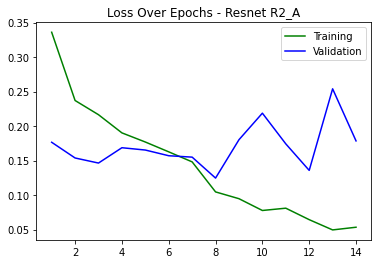

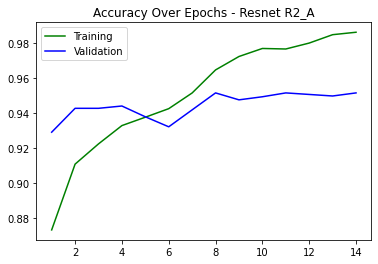

In [22]:
PlotHistory(hist,"Resnet R2_A")

**The model ResNet50 R1 B has achieved an accuracy of 95.16% with an F-score of 0.95**



__________

## ResNet50 R3 <a class="anchor" id="r3"></a>

**Fine tuning the pre trained model**

We take the ResNet50 R2, unfreeze all the layers from ResNet50 model. Finetune the entire model (including the weights of the pretrained model) using a very very less learning rate, to adapt the model to our data

In [24]:
for layer in resnet_R2_A.layers:
    print(layer,layer.trainable)


#Checking which ones are trainable

<keras.engine.input_layer.InputLayer object at 0x00000224DA9AFC70> False
<keras.layers.convolutional.ZeroPadding2D object at 0x00000224DBBFE8B0> False
<keras.layers.convolutional.Conv2D object at 0x00000224DBBFEC70> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x00000224DBC8BB50> False
<keras.layers.core.activation.Activation object at 0x00000224DBCD6130> False
<keras.layers.convolutional.ZeroPadding2D object at 0x00000224DBCD6D60> False
<keras.layers.pooling.MaxPooling2D object at 0x00000224DFD19DC0> False
<keras.layers.convolutional.Conv2D object at 0x00000224DFD313A0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x00000224DFD31040> False
<keras.layers.core.activation.Activation object at 0x00000224DFD37A00> False
<keras.layers.convolutional.Conv2D object at 0x00000224DFD3C5B0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x00000224DFD3C370> False
<keras.layers.core.activ

In [25]:
#Now we use the model and weights obtained from the previous step
#We unfreeze the conv blocks and use very small learning rate and few epochs 

resnet_R2.trainable = True 


resnet_R2_A.compile(
  loss='categorical_crossentropy',
 optimizer=keras.optimizers.Adam(1e-5),
  metrics=['accuracy']
)






In [34]:
resnet_R3 = resnet_R2_A

In [35]:
hist = resnet_R3.fit_generator(
  TrainDataLoader,
  validation_data=ValDataLoader,
  epochs=30,
  steps_per_epoch=len(TrainDataLoader),
  validation_steps=len(ValDataLoader),
  callbacks = callbacks
)

Epoch 1/30
1256/1256 [==============================] - ETA: 0s - loss: 0.0937 - accuracy: 0.9752
Epoch 1: val_loss did not improve from 0.12470
1256/1256 [==============================] - 165s 131ms/step - loss: 0.0937 - accuracy: 0.9752 - val_loss: 0.4878 - val_accuracy: 0.9525 - lr: 2.0000e-06
Epoch 2/30
1256/1256 [==============================] - ETA: 0s - loss: 0.0755 - accuracy: 0.9782
Epoch 2: val_loss did not improve from 0.12470
1256/1256 [==============================] - 165s 131ms/step - loss: 0.0755 - accuracy: 0.9782 - val_loss: 0.6474 - val_accuracy: 0.9494 - lr: 2.0000e-06
Epoch 3/30
1256/1256 [==============================] - ETA: 0s - loss: 0.0781 - accuracy: 0.9765
Epoch 3: val_loss did not improve from 0.12470
1256/1256 [==============================] - 169s 134ms/step - loss: 0.0781 - accuracy: 0.9765 - val_loss: 0.4064 - val_accuracy: 0.9516 - lr: 2.0000e-06
Epoch 4/30
1256/1256 [==============================] - ETA: 0s - loss: 0.0703 - accuracy: 0.9792
Epoch

In [36]:
PredsR3 = resnet_R3.predict_generator(TestDataLoader) 
PredsR3 = np.argmax(PredsR3,axis=1)

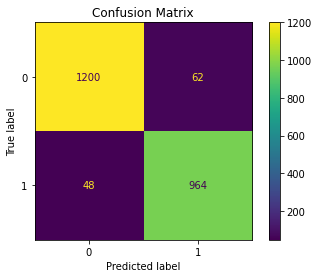

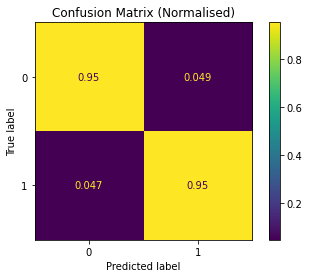

In [37]:
ConfusionMatrixMetrics(TestDataLoader.classes,PredsR3)

In [38]:
acc_R3 =  accuracy_score(TestDataLoader.classes,PredsR3)

print(f'The model has an accuracy of {(acc_R3*100):.2f}%')

The model has an accuracy of 95.16%


In [39]:
print(classification_report(TestDataLoader.classes, PredsR3, target_names=Classes))

              precision    recall  f1-score   support

     Organic       0.96      0.95      0.96      1262
  Recyclable       0.94      0.95      0.95      1012

    accuracy                           0.95      2274
   macro avg       0.95      0.95      0.95      2274
weighted avg       0.95      0.95      0.95      2274



In [40]:
f1_R3 = 0.95

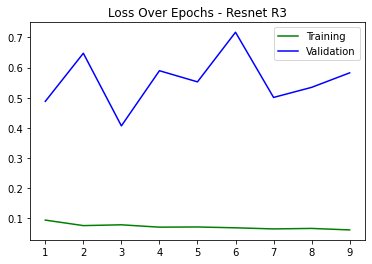

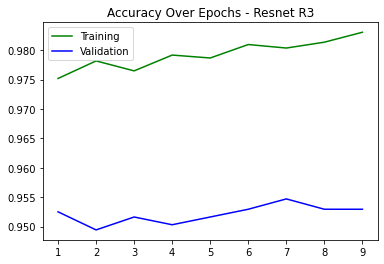

In [41]:
PlotHistory(hist,"Resnet R3")

**The model ResNet50 R1 B has achieved an accuracy of 95.16% with an F-score of 0.95**

The network performance has not improved, this may be because of the ess number of training samples (compared to the original one million images used for pre training)

## Transfer Learning Analysis <a class="anchor" id="resnetanalysis"></a>

**Summarising results from above experiments**

| Experiment | Experiment | Accuracy % | F-Score |
| --- | --- | --- | --- |
| ResNet50 R1 A | Changing only output layer | 94.42% | 0.94 |
| ResNet50 R1 B | Using Data Augmentations on ResNet50 R1 | 94.94% | 0.95 |
| ResNet50 R2 | Using ResNet50 as feature extractor, and Baseline B7 on top of it as classifier | 95.16% | 0.95 |
| ResNet50 R3 | Finetuning entire ResNet50 R2 | 95.16% | 0.95 |

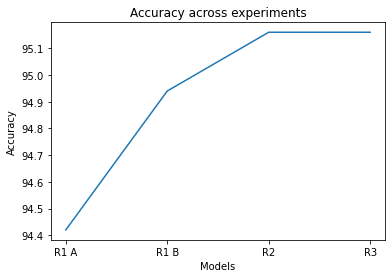

In [29]:
y = [acc_R1_A*100,acc_R1_B*100,acc_R2*100,acc_R3*100]
x = ["R1 A","R1 B","R2","R3"]

plt.plot(x,y)
plt.title("Accuracy across experiments")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.show()


**Summary**

(Experiment ResNet50 R1 A) : We have started with using the ResNet50 as the classifier.

(Experiment ResNet50 R1 B) : We only swap the output layer and use the pretrained image net weights. Since, from our baseline experiments, we have learnt that Data Augmentation improves the performance of the model, we have used the same data augmentations used earlier, now on Resnet50 R1 A. 

We have also seen that, data normalisation improves the performance of the model, but since ResNet50 has its own input preprocessing, we havent included any additional data normalisation.

(Experiment ResNet50 R2) : We use ResNet50 as the feature extractor, by removing all the dense layers. On top of it we built the Baseline B7 model (with all the batch norms and dropouts). We freeze the ResNet50 weights and only train the B7 model on top of it

(Experiment ResNet50 R3) : We unfreeze all the layers from ResNet50 R2, and fine tune the entire pre trained model for our data


## Analysis <a class="anchor" id="analysis"></a>


**Summarising the results from all the experiments**

| Experiment | Experiment | Accuracy % | F-Score |
| --- | --- | --- | --- |
| Baseline B1 | Base Model | 84.74% | 0.84 |
| Baseline B2 32 | Image Size 32 | 84.74% | 0.84 |
| Baseline B2 64 | Image Size 64 | 86.56% | 0.86 |
| Baseline B2 128 | Image Size 128 | 83.14% | 0.83 |
| Baseline B2 224 | Image Size 224 | 80.83% | 0.81 |
| Baseline B3 128 | Deeper Network | 88.46% | 0.88 |
| Baseline B3 224 | Deeper Network | 89.22% | 0.89 |
| Baseline B4 A | Pixel Normalization | 87.76% | 0.88 |
| Baseline B4 B | Centering & Standardizing | 88.02% | 0.88 |
| Baseline B5 A | Aggressive Data Augmentations | 87.29% | 0.87 |
| Baseline B5 B | Less aggressive Data Augmentations | 90.42% | 0.90 |
| Baseline B6 | Batch Normalisations | 91.13% | 0.91 |
| Baseline B7 | Dropouts | 91.88% | 0.92 |
| ResNet50 R1 A | Changing only output layer | 94.42% | 0.94 |
| ResNet50 R1 B | Using Data Augmentations on ResNet50 R1 | 94.94% | 0.95 |
| ResNet50 R2 | Using ResNet50 as feature extractor, and Baseline B7 on top of it as classifier | 95.16% | 0.95 |
| ResNet50 R3 | Finetuning entire ResNet50 R2 | 95.16% | 0.95 |


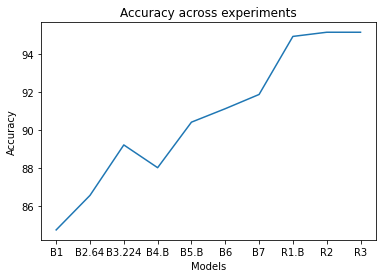

In [33]:
y = [acc_B1*100,acc_B2_64*100,acc_B3_224*100,acc_B4_B*100,acc_B5_B*100,acc_B6*100,acc_B7*100,acc_R1_B*100,acc_R2*100,acc_R3*100]
x = ["B1","B2.64","B3.224","B4.B","B5.B","B6","B7","R1.B","R2","R3"]

plt.plot(x,y)
plt.title("Accuracy across experiments")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.show()

**Conclusion**

From the plot above, we can see how accuracy of the model has been improved from around 84% to around 95%.

To improve the model performance, various tecchniques and design choices have been experimented with. Amongst them, the ones that improve the model have been choosed and incorporated into further experiments.

Firstly, the input image size and the network depth have been increased. This resulted in increased accuracy of the model.

Then, Data Normalisation techniques have been explored and experimented with. Centering & Standardising the inputs gave the best results.

Later, several Data Augmentation techniques have been explored. A less agressive data augmentations were finalised, which imrpove the performance of the model.

Then, Batchnormalisation and Dropouts have been carefullt designed and placed to boost the performance of the model.

Transfer learning techniques have been used to further boost the performance of the model. 

**PreTrained Model used as feature extractor & Baseline B7 model built on top of it as classifier, gave the best results amongs all the experiment**

This can be attributed to the highly efficient pretrained model and carefully built Baseline B7 model, that is built from scratch for this specific task and data